# SWB Computational Models

- Winning model from 2014 "A computational and neural model of momentary subjective well-being"
- Adapted to include counterfactual information 

Created: 05/04/2023 by Alie Fink
Updated: 01/14/2024

In [82]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
import scipy
from scipy.optimize import least_squares, minimize
import sklearn
from sklearn.metrics import r2_score
import random
import tqdm
from scipy.stats import spearmanr, norm
import statsmodels.api as sm
import os
import pickle
import datetime
from joblib import Parallel, delayed
import itertools


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [83]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [84]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils

In [85]:
# set directories
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
behav_dir = f'{base_dir}behavior_analysis/behavior_preprocessed/'
# create fig saving directory
fig_dir = f'{base_dir}swb_computational_modeling/swb_behav_models/figs/swb_pt_glms/'
os.makedirs(fig_dir,exist_ok = True) 

# get date info for data/fig saving
date = datetime.date.today().strftime('%m%d%Y')
print(date)

01142024


In [86]:
subj_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0])
subj_ids = list(subj_list.PatientID)

In [87]:
bdi_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
bai_list = pd.read_excel(f'{base_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[4])
bai_list = list(bai_list.SWB_BAI)

In [88]:
%matplotlib inline

#### set theme for all plots
sns.set_theme(style='ticks',font='Arial') 
sns.set_context("talk")

# Prospect Theory Parameters for SWB Subj
- save data into task dfs
- create regression df for ephys regression
- update model_data inputs for GLMs

In [89]:
# load subj fits for mle + em map 

pt_mle_fits = pickle.load(open(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/swb_pt_MLE_dict_01142024.pkl','rb'))
# pt_mle_fits
pt_emmap_fits = pickle.load(open(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/swb_pt_EMMAP_fit_subj_dicts_01142024.pkl','rb')) 
# pt_emmap_fits


In [90]:
# MLE 
# extract estimated params for all subj

risk_mle    = []
loss_mle    = []
invtemp_mle = []
negll_mle   = []
bic_mle     = []


for subj_id in subj_ids: 
    subj_data = pt_mle_fits[subj_id]['subj_dict']
    risk_mle.append(subj_data['params'][0])
    loss_mle.append(subj_data['params'][1])
    invtemp_mle.append(subj_data['params'][2])
    negll_mle.append(subj_data['negll'])
    bic_mle.append(subj_data['BIC'])
    

In [91]:
# EM MAP 
# extract estimated params for all subj

risk_emmap     = []
loss_emmap     = []
invtemp_emmap  = []
negll_emmap    = []
bic_emmap      = []


for subj_id in subj_ids: 
    subj_data = pt_emmap_fits[subj_id]
    risk_emmap.append(subj_data['params'][0])
    loss_emmap.append(subj_data['params'][1])
    invtemp_emmap.append(subj_data['params'][2])
    negll_emmap.append(subj_data['negll'])
    bic_emmap.append(subj_data['bic'])

In [92]:
# combine mle and emmap info into df + save

### make summary df of all pt info 
df_data_dict = {'subj_id':subj_ids,'risk_mle':risk_mle,'loss_mle':loss_mle,'invtemp_mle':invtemp_mle,'negll_mle':negll_mle,'bic_mle':bic_mle,
                'risk_emmap':risk_emmap,'loss_emmap':loss_emmap,'invtemp_emmap':invtemp_emmap,'negll_emmap':negll_emmap,'bic_emmap':bic_emmap,
                'bdi':bdi_list,'bai':bai_list}

pt_params_df = pd.DataFrame(df_data_dict)
pt_params_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/pt_params_mle_emmap_df_{date}.csv')
    
pt_params_df

,subj_id,risk_mle,loss_mle,invtemp_mle,negll_mle,bic_mle,risk_emmap,loss_emmap,invtemp_emmap,negll_emmap,bic_emmap,bdi,bai
0,DA8,1.212121,5.111117,2.625557,55.476387,125.984681,1.161590,3.666231,3.541822,55.963529,126.958964,13,0
1,DA9,1.484386,0.836855,3.261053,81.634586,178.301077,1.334604,0.818940,3.696060,81.946609,178.925124,32,0
2,DA10,0.781768,1.727190,3.058602,90.215432,195.462769,0.795437,1.659771,3.196416,90.240148,195.512203,11,0
3,DA11,1.199625,0.226255,1.527750,96.929642,208.891190,1.000752,0.429149,2.297940,97.347112,209.726129,41,0
4,DA023,0.994608,1.864381,2.089041,91.022847,197.077600,0.965702,1.693014,2.521667,91.145881,197.323668,14,0
5,DA026,0.564950,2.148784,2.429444,88.984904,193.001714,0.590956,1.870426,3.037436,89.119384,193.270674,19,36
6,MS002,0.817053,3.421697,1.387247,88.149899,191.331703,0.805767,2.295807,2.387465,88.556058,192.144022,14,0
7,MS003,0.733124,0.000010,5.115220,85.857590,186.747086,0.759944,0.128203,4.769846,86.927146,188.886198,8,0
8,MS004,0.711023,6.000000,0.316979,100.327488,215.686883,0.691662,1.803040,1.626593,101.776484,218.584874,7,4
9,MS016,0.623760,0.969737,6.760218,87.034070,189.100046,0.645710,1.001507,5.244064,87.523735,190.079377,10,5


In [ ]:
# summary stats for fit quality
    # param means
    # param ranges
    # params @ bounds

In [93]:
pt_summary_df = {'risk_mle_mean':np.mean(risk_mle),'risk_mle_min':np.min(risk_mle),'risk_mle_max':np.max(risk_mle),
              'n_risk_bad_mle':[np.sum(pt_params_df.risk_mle==2)+np.sum(pt_params_df.risk_mle==0.00001)],
              'loss_mle_mean':np.mean(loss_mle),'loss_mle_min':np.min(loss_mle),'loss_mle_max':np.max(loss_mle),
              'n_loss_bad_mle':[np.sum(pt_params_df.loss_mle==6)+np.sum(pt_params_df.loss_mle==0.00001)],
              'invtemp_mle_mean':np.mean(invtemp_mle),'invtemp_mle_min':np.min(invtemp_mle),'invtemp_mle_max':np.max(invtemp_mle),
              'n_invtemp_bad_mle':[np.sum(pt_params_df.invtemp_mle==10)+np.sum(pt_params_df.invtemp_mle==0.00001)],
              'bic_mean_mle':np.mean(bic_mle),'bic_min_mle':np.min(bic_mle),'bic_max_mle':np.max(bic_mle),
              'negll_mean_mle':np.mean(negll_mle),'negll_min_mle':np.min(negll_mle),'negll_max_mle':np.max(negll_mle),
#
              'risk_emmap_mean':np.mean(risk_emmap),'risk_emmap_min':np.min(risk_emmap),'risk_emmap_max':np.max(risk_emmap),
              'n_risk_bad_emmap':[np.sum(pt_params_df.risk_emmap==2)+np.sum(pt_params_df.risk_emmap==0.00001)],
              'loss_emmap_mean':np.mean(loss_emmap),'loss_emmap_min':np.min(loss_emmap),'loss_emmap_max':np.max(loss_emmap),
              'n_loss_bad_emmap':[np.sum(pt_params_df.loss_emmap==6)+np.sum(pt_params_df.loss_emmap==0.00001)],
              'invtemp_emmap_mean':np.mean(invtemp_emmap),'invtemp_emmap_min':np.min(invtemp_emmap),'invtemp_emmap_max':np.max(invtemp_emmap),
              'n_invtemp_bad_emmap':[np.sum(pt_params_df.invtemp_emmap==10)+np.sum(pt_params_df.invtemp_emmap==0.00001)],
              'bic_mean_emmap':np.mean(bic_emmap),'bic_min_emmap':np.min(bic_emmap),'bic_max_emmap':np.max(bic_emmap),
              'negll_mean_emmap':np.mean(negll_emmap),'negll_min_emmap':np.min(negll_emmap),'negll_max_emmap':np.max(negll_emmap)}


pt_summary_df = pd.DataFrame(pt_summary_df)
pt_summary_df.to_csv(f'{base_dir}swb_computational_modeling/swb_behav_models/data/swb_pt_subj_fits/pt_summary_mle_emmap_df_{date}.csv')


In [94]:
all_pt_data = {}

for subj_id in subj_ids: 
    # get mle df 
    mle_data = pt_mle_fits[subj_id]['subj_dict']
    # get emmap df 
    emmap_data = pt_emmap_fits[subj_id]
    all_pt_data[subj_id] = {'mle_data':mle_data,
                            'emmap_data':emmap_data
                            }
    

In [119]:
# load task data for each subj, calculate pt params, add all params to subj task_data & save as pt_task_data
    # just add - utilsafe, utilgamble, utilchoice, wsafe, whigh, wlow, psafe, pgamble x 2 for mle & emmap
    # need to calculate then add - utiltCPE, utildCPE, utiltRegret, utildRegret, utiltRelief, utildRelief, utilRPe, utilpRPE,utilnRPE x 2 for mle & emmap
    
pt_task_dfs = []

for subj_id in subj_ids:
    #load preprocessed task data with model-free params
    subj_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
    #load pt fits data dicts 
        #load mle subj data
    mle_data = pt_mle_fits[subj_id]['subj_dict']
        #emmap param calculations
    emmap_data = pt_emmap_fits[subj_id]

    #add already calculated mle params to subj df
    subj_df['util_safe_mle']   = mle_data['util_safe']
    subj_df['util_gamble_mle'] = mle_data['util_gamble']
    # subj_df['util_choice_mle'] = mle_data['ChoiceUtil'] #only length 149?
    subj_df['wSafe_mle']       = mle_data['WeightedSafe']
    subj_df['wHigh_mle']       = mle_data['WeightedHigh']
    subj_df['wLow_mle']        = mle_data['WeightedLow']
    subj_df['p_safe_mle']      = mle_data['p_safe']
    subj_df['p_gamble_mle']    = mle_data['p_gamble']

    
    #already calculated emmap params to subj_df 
    subj_df['util_safe_emmap']   = emmap_data['util_safe']
    subj_df['util_gamble_emmap'] = emmap_data['util_gamble']
    # subj_df['util_choice_emmap'] = emmap_data['ChoiceUtil'] #only length 149?
    subj_df['wSafe_emmap']       = emmap_data['WeightedSafe']
    subj_df['wHigh_emmap']       = emmap_data['WeightedHigh']
    subj_df['wLow_emmap']        = emmap_data['WeightedLow']
    subj_df['p_safe_emmap']      = emmap_data['p_safe']
    subj_df['p_gamble_emmap']    = emmap_data['p_gamble']

    #calculate cpe/rpe params + add to subj df 
        #must loop through subj_df 
    #mle var calculations
    tcpe_mle = []
    dcpe_mle = []
    tcf_mle  = []
    dcf_mle  = []
    treg_mle = []
    dreg_mle = []
    trel_mle = []
    drel_mle = []
    rpe_mle  = []
    prpe_mle = []
    nrpe_mle = []
    #emmap var calculations
    tcpe_emmap = []
    dcpe_emmap = []
    tcf_emmap  = []
    dcf_emmap  = []
    treg_emmap = []
    dreg_emmap = []
    trel_emmap = []
    drel_emmap = []
    rpe_emmap  = []
    prpe_emmap = []
    nrpe_emmap = []

    for t in range(len(subj_df)):
        trial_info = subj_df.iloc[t]
        if trial_info['GambleChoice']=='gamble':
            # subj choice = gamble
            if trial_info['Outcome']=='good':
            # gamble outcome = good > won high bet 
                
                # cpe calculations
                tcpe_mle.append(mle_data['WeightedHigh'][t]-mle_data['WeightedLow'][t])
                tcpe_emmap.append(emmap_data['WeightedHigh'][t]-emmap_data['WeightedLow'][t])
                dcpe_mle.append(mle_data['WeightedHigh'][t]-mle_data['WeightedSafe'][t])
                dcpe_emmap.append(emmap_data['WeightedHigh'][t]-emmap_data['WeightedSafe'][t])
                tcf_mle.append(mle_data['WeightedLow'][t]) #### consider whether these should be positive or negative later
                tcf_emmap.append(emmap_data['WeightedLow'][t]) 
                dcf_mle.append(mle_data['WeightedSafe'][t])
                dcf_emmap.append(emmap_data['WeightedSafe'][t])

                # regret calculations
                treg_mle.append(0)
                treg_emmap.append(0)
                dreg_mle.append(0)
                dreg_emmap.append(0)

                # relief calculations
                trel_mle.append(mle_data['WeightedHigh'][t]-mle_data['WeightedLow'][t])
                trel_emmap.append(emmap_data['WeightedHigh'][t]-emmap_data['WeightedLow'][t])
                drel_mle.append(mle_data['WeightedHigh'][t]-mle_data['WeightedSafe'][t])
                drel_emmap.append(emmap_data['WeightedHigh'][t]-emmap_data['WeightedSafe'][t])

                # rpe calculations
                rpe_mle.append(mle_data['WeightedHigh'][t]-mle_data['util_gamble'][t])
                rpe_emmap.append(emmap_data['WeightedHigh'][t]-emmap_data['util_gamble'][t])
                prpe_mle.append(mle_data['WeightedHigh'][t]-mle_data['util_gamble'][t])
                prpe_emmap.append(emmap_data['WeightedHigh'][t]-emmap_data['util_gamble'][t])
                nrpe_mle.append(0)
                nrpe_emmap.append(0)


            elif trial_info['Outcome']=='bad':
            # gamble outcome = bad > won low bet 
                
                # cpe calculations
                tcpe_mle.append(mle_data['WeightedLow'][t]-mle_data['WeightedHigh'][t])
                tcpe_emmap.append(emmap_data['WeightedLow'][t]-emmap_data['WeightedHigh'][t])
                dcpe_mle.append(mle_data['WeightedLow'][t]-mle_data['WeightedSafe'][t])
                dcpe_emmap.append(emmap_data['WeightedLow'][t]-emmap_data['WeightedSafe'][t])
                tcf_mle.append(mle_data['WeightedHigh'][t])
                tcf_emmap.append(emmap_data['WeightedHigh'][t])
                dcf_mle.append(mle_data['WeightedSafe'][t])
                dcf_emmap.append(emmap_data['WeightedSafe'][t])

                # regret calculations
                treg_mle.append(mle_data['WeightedLow'][t]-mle_data['WeightedHigh'][t])                
                treg_emmap.append(emmap_data['WeightedLow'][t]-emmap_data['WeightedHigh'][t])
                dreg_mle.append(mle_data['WeightedLow'][t]-mle_data['WeightedSafe'][t])
                dreg_emmap.append(emmap_data['WeightedLow'][t]-emmap_data['WeightedSafe'][t])

                # relief calculations
                trel_mle.append(0)
                trel_emmap.append(0)
                drel_mle.append(0)
                drel_emmap.append(0)

                # rpe calculations
                rpe_mle.append(mle_data['WeightedLow'][t]-mle_data['util_gamble'][t])
                rpe_emmap.append(emmap_data['WeightedLow'][t]-emmap_data['util_gamble'][t])
                prpe_mle.append(0)
                prpe_emmap.append(0)
                nrpe_mle.append(mle_data['WeightedLow'][t]-mle_data['util_gamble'][t])
                nrpe_emmap.append(emmap_data['WeightedLow'][t]-emmap_data['util_gamble'][t])

            else: 
            #fail trials
                tcpe_mle.append(0)
                tcpe_emmap.append(0)
                dcpe_mle.append(0)
                dcpe_emmap.append(0)
                tcf_mle.append(0)
                tcf_emmap.append(0)
                dcf_mle.append(0)
                dcf_emmap.append(0)
                treg_mle.append(0)
                treg_emmap.append(0)
                dreg_mle.append(0)
                dreg_emmap.append(0)
                trel_mle.append(0)
                trel_emmap.append(0)
                drel_mle.append(0)
                drel_emmap.append(0)
                rpe_mle.append(0)
                rpe_emmap.append(0)
                prpe_mle.append(0)
                prpe_emmap.append(0)
                nrpe_mle.append(0)
                nrpe_emmap.append(0)


        elif trial_info['GambleChoice']=='safe':
            # subj choice = safe
            if trial_info['Outcome']=='good':
            # safe outcome = good > would have won low bet 
                
                # cpe calculations
                tcpe_mle.append(mle_data['WeightedSafe'][t]-mle_data['WeightedLow'][t])
                tcpe_emmap.append(emmap_data['WeightedSafe'][t]-emmap_data['WeightedLow'][t])
                dcpe_mle.append(mle_data['WeightedSafe'][t]-mle_data['WeightedLow'][t])
                dcpe_emmap.append(emmap_data['WeightedSafe'][t]-emmap_data['WeightedLow'][t])
                tcf_mle.append(mle_data['WeightedLow'][t])
                tcf_emmap.append(emmap_data['WeightedLow'][t])
                dcf_mle.append(mle_data['WeightedLow'][t])
                dcf_emmap.append(emmap_data['WeightedLow'][t])
                
                # regret calculations
                treg_mle.append(0)
                treg_emmap.append(0)
                dreg_mle.append(0)
                dreg_emmap.append(0)

                # relief calculations
                trel_mle.append(mle_data['WeightedSafe'][t]-mle_data['WeightedLow'][t])
                trel_emmap.append(emmap_data['WeightedSafe'][t]-emmap_data['WeightedLow'][t])
                drel_mle.append(mle_data['WeightedSafe'][t]-mle_data['WeightedLow'][t])
                drel_emmap.append(emmap_data['WeightedSafe'][t]-emmap_data['WeightedLow'][t])
                
                # rpe calculations
                rpe_mle.append(0)
                rpe_emmap.append(0)
                prpe_mle.append(0)
                prpe_emmap.append(0)
                nrpe_mle.append(0)
                nrpe_emmap.append(0)

            elif trial_info['Outcome']=='bad':
            # safe outcome = bad > would have won high bet
                
                # cpe calculations
                tcpe_mle.append(mle_data['WeightedSafe'][t]-mle_data['WeightedHigh'][t])
                tcpe_emmap.append(emmap_data['WeightedSafe'][t]-emmap_data['WeightedHigh'][t])
                dcpe_mle.append(mle_data['WeightedSafe'][t]-mle_data['WeightedHigh'][t])
                dcpe_emmap.append(emmap_data['WeightedSafe'][t]-emmap_data['WeightedHigh'][t])
                tcf_mle.append(mle_data['WeightedHigh'][t])
                tcf_emmap.append(emmap_data['WeightedHigh'][t])
                dcf_mle.append(mle_data['WeightedHigh'][t])
                dcf_emmap.append(emmap_data['WeightedHigh'][t])
                
                # regret calculations
                treg_mle.append(mle_data['WeightedSafe'][t]-mle_data['WeightedHigh'][t])                
                treg_emmap.append(emmap_data['WeightedSafe'][t]-emmap_data['WeightedHigh'][t])
                dreg_mle.append(mle_data['WeightedSafe'][t]-mle_data['WeightedHigh'][t])
                dreg_emmap.append(emmap_data['WeightedSafe'][t]-emmap_data['WeightedHigh'][t])

                # relief calculations
                trel_mle.append(0)
                trel_emmap.append(0)
                drel_mle.append(0)
                drel_emmap.append(0)

                # rpe calculations
                rpe_mle.append(0)
                rpe_emmap.append(0)
                prpe_mle.append(0)
                prpe_emmap.append(0)
                nrpe_mle.append(0)
                nrpe_emmap.append(0)

            else: 
            #fail trials    
                tcpe_mle.append(0)
                tcpe_emmap.append(0)
                dcpe_mle.append(0)
                dcpe_emmap.append(0)
                tcf_mle.append(0)
                tcf_emmap.append(0)
                dcf_mle.append(0)
                dcf_emmap.append(0)
                treg_mle.append(0)
                treg_emmap.append(0)
                dreg_mle.append(0)
                dreg_emmap.append(0)
                trel_mle.append(0)
                trel_emmap.append(0)
                drel_mle.append(0)
                drel_emmap.append(0)
                rpe_mle.append(0)
                rpe_emmap.append(0)
                prpe_mle.append(0)
                prpe_emmap.append(0)
                nrpe_mle.append(0)
                nrpe_emmap.append(0)

        else: 
        #fail trials
            tcpe_mle.append(0)
            tcpe_emmap.append(0)
            dcpe_mle.append(0)
            dcpe_emmap.append(0)
            tcf_mle.append(0)
            tcf_emmap.append(0)
            dcf_mle.append(0)
            dcf_emmap.append(0)
            treg_mle.append(0)
            treg_emmap.append(0)
            dreg_mle.append(0)
            dreg_emmap.append(0)
            trel_mle.append(0)
            trel_emmap.append(0)
            drel_mle.append(0)
            drel_emmap.append(0)
            rpe_mle.append(0)
            rpe_emmap.append(0)
            prpe_mle.append(0)
            prpe_emmap.append(0)
            nrpe_mle.append(0)
            nrpe_emmap.append(0)

    
    #add calculated cpe/rpe mle params to subj df 
    subj_df['util_tCPE_mle']     = tcpe_mle
    subj_df['util_dCPE_mle']     = dcpe_mle
    subj_df['util_tCF_mle']      = tcf_mle
    subj_df['util_dCF_mle']      = dcf_mle
    subj_df['util_tRegret_mle']  = treg_mle
    subj_df['util_dRegret_mle']  = dreg_mle
    subj_df['util_tRelief_mle']  = trel_mle
    subj_df['util_dRelief_mle']  = drel_mle
    subj_df['util_RPE_mle']      = rpe_mle
    subj_df['util_pRPE_mle']     = prpe_mle
    subj_df['util_nRPE_mle']     = nrpe_mle

    #add calculated cpe/rpe emmap params to subj df 
    subj_df['util_tCPE_emmap']     = tcpe_emmap
    subj_df['util_dCPE_emmap']     = dcpe_emmap
    subj_df['util_tCF_emmap']      = tcf_emmap
    subj_df['util_dCF_emmap']      = dcf_emmap
    subj_df['util_tRegret_emmap']  = treg_emmap
    subj_df['util_dRegret_emmap']  = dreg_emmap
    subj_df['util_tRelief_emmap']  = trel_emmap
    subj_df['util_dRelief_emmap']  = drel_emmap
    subj_df['util_RPE_emmap']      = rpe_emmap
    subj_df['util_pRPE_emmap']     = prpe_emmap
    subj_df['util_nRPE_emmap']     = nrpe_emmap

    #append to list of all subj dfs
    pt_task_dfs.append(subj_df) 

    #save new task df as pt_task_data
    subj_df.to_csv(f'{behav_dir}{subj_id}_pt_task_data')



## Visualize Param Fits from MLE and EM MAP

In [122]:
pt_params_df

,subj_id,risk_mle,loss_mle,invtemp_mle,negll_mle,bic_mle,risk_emmap,loss_emmap,invtemp_emmap,negll_emmap,bic_emmap,bdi,bai
0,DA8,1.212121,5.111117,2.625557,55.476387,125.984681,1.161590,3.666231,3.541822,55.963529,126.958964,13,0
1,DA9,1.484386,0.836855,3.261053,81.634586,178.301077,1.334604,0.818940,3.696060,81.946609,178.925124,32,0
2,DA10,0.781768,1.727190,3.058602,90.215432,195.462769,0.795437,1.659771,3.196416,90.240148,195.512203,11,0
3,DA11,1.199625,0.226255,1.527750,96.929642,208.891190,1.000752,0.429149,2.297940,97.347112,209.726129,41,0
4,DA023,0.994608,1.864381,2.089041,91.022847,197.077600,0.965702,1.693014,2.521667,91.145881,197.323668,14,0
5,DA026,0.564950,2.148784,2.429444,88.984904,193.001714,0.590956,1.870426,3.037436,89.119384,193.270674,19,36
6,MS002,0.817053,3.421697,1.387247,88.149899,191.331703,0.805767,2.295807,2.387465,88.556058,192.144022,14,0
7,MS003,0.733124,0.000010,5.115220,85.857590,186.747086,0.759944,0.128203,4.769846,86.927146,188.886198,8,0
8,MS004,0.711023,6.000000,0.316979,100.327488,215.686883,0.691662,1.803040,1.626593,101.776484,218.584874,7,4
9,MS016,0.623760,0.969737,6.760218,87.034070,189.100046,0.645710,1.001507,5.244064,87.523735,190.079377,10,5


In [123]:
risk_corr, risk_p = spearmanr(pt_params_df.risk_mle, pt_params_df.risk_emmap)
print('Spearman correlation: %.3f' % risk_corr)
print(risk_p)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Spearman correlation: 0.960
6.238818356262163e-12


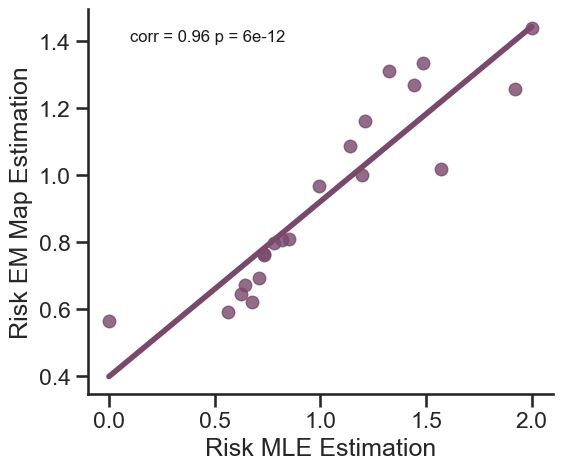

In [131]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.risk_mle, y=pt_params_df.risk_emmap,color = '#78496b',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.1, 1.4,f'corr = {np.round(risk_corr,2)} p = {np.round(risk_p,12)}',fontsize=12,color = 'k')
plt.xlabel('Risk MLE Estimation')
plt.ylabel('Risk EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}risk_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [132]:
loss_corr, loss_p = spearmanr(pt_params_df.loss_mle, pt_params_df.loss_emmap)
print('Spearman correlation: %.3f' % loss_corr)
print(loss_p)

Spearman correlation: 0.974Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

1.1702563698328304e-13


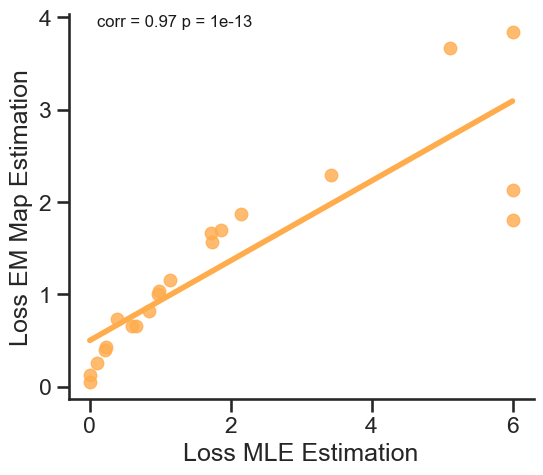

In [135]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.loss_mle, y=pt_params_df.loss_emmap,color = '#ffac4d',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.1, 3.9,f'corr = {np.round(loss_corr,2)} p = {np.round(loss_p,13)}',fontsize=12,color = 'k')
plt.xlabel('Loss MLE Estimation')
plt.ylabel('Loss EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}loss_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [136]:
invtemp_corr, invtemp_p = spearmanr(pt_params_df.invtemp_mle, pt_params_df.invtemp_emmap)
print('Spearman correlation: %.3f' % invtemp_corr)
print(invtemp_p)

Spearman correlation: 0.968Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

8.33318722559804e-13


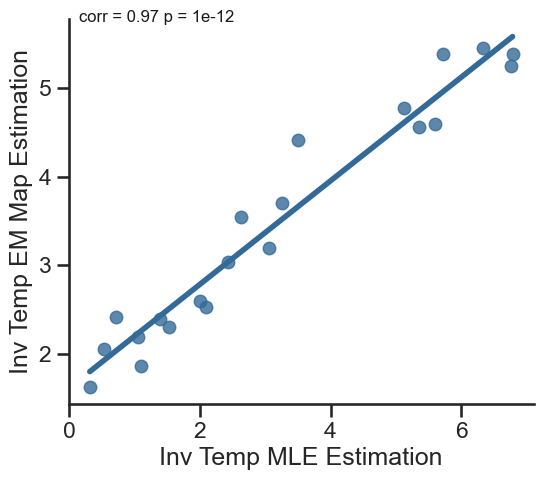

In [140]:
## MLE vs EM MAP Risk Estimations
# plt.scatter(subj_bdi,risk_est,color = '#78496b')
fig,ax = plt.subplots(figsize=(6,5))

sns.regplot(ax=ax,x=pt_params_df.invtemp_mle, y=pt_params_df.invtemp_emmap,color = '#346a97',ci=None,scatter=True,line_kws={"linewidth": 4})
ax.text(0.15, 5.75,f'corr = {np.round(invtemp_corr,2)} p = {np.round(invtemp_p,12)}',fontsize=12,color = 'k')
plt.xlabel('Inv Temp MLE Estimation')
plt.ylabel('Inv Temp EM Map Estimation')
sns.despine()


plt.savefig(f'{fig_dir}invtemp_mle_emmap_corr_{date}.pdf', dpi=500, format='pdf', metadata=None,
bbox_inches='tight', pad_inches=0.2,
facecolor='auto', edgecolor='auto',
backend=None) 

In [ ]:
# negll comparisons 
# bic comparisons 

# Fit GLMs
- validate swb eq code is working
- troubleshoot fitting on small models
- improve workflow
- run full GLMs on all possible param combos 
- 

In [ ]:

def get_model_data_pt(subj_id,task_df,rate_df):
    model_data_dict = {}

    #get rating info
    round = rate_df['Round'][max(loc for loc, val in enumerate(rate_df['Round']) if val == 1)+1:] #need index of last round 1 because some pts have multiple round 1 scores, start after last round 1 index
    rate = rate_df['Rating'][max(loc for loc, val in enumerate(rate_df['Round']) if val == 1)+1:]
    zscore_rate = rate_df['zscore_mood'][max(loc for loc, val in enumerate(rate_df['Round']) if val == 1)+1:]


    cr1 = []
    cr2 = []
    cr3 = []
    ev1 = []
    ev2 = []
    ev3 = []
    rpe1 = []
    rpe2 = []
    rpe3 = []
    tcpe1 = []
    tcpe2 = []
    tcpe3 = []
    dcpe1 = []
    dcpe2 = []
    dcpe3 = []
    treg1 = []
    treg2 = []
    treg3 = []
    dreg1 = []
    dreg2 = []
    dreg3 = []
    trel1 = []
    trel2 = []
    trel3 = []
    drel1 = []
    drel2 = []
    drel3 = []
    utilG1 = []
    utilG2 = []
    utilG3 = []
    utilS1 = []
    utilS2 = []
    utilS3 = []
    utilrpe1 = []
    utilrpe2 = []
    utilrpe3 = []
    utiltcpe1 = []
    utiltcpe2 = []
    utiltcpe3 = []
    utildcpe1 = []
    utildcpe2 = []
    utildcpe3 = []
    utiltregret1 = []
    utiltregret2 = []
    utiltregret3 = []
    utildregret1 = []
    utildregret2 = []
    utildregret3 = []
    utiltrelief1 = []
    utiltrelief2 = []
    utiltrelief3 = []
    utildrelief1 = []
    utildrelief2 = []
    utildrelief3 = []

    for r in round:
        #index for task df
        t3 = r-4 #t-3 trial 
        t2 = r-3 #t-2 trial
        t1 = r-2 #t-1 trial
        
        cr1.append(task_df['CR'][t1])
        cr2.append(task_df['CR'][t2])
        cr3.append(task_df['CR'][t3])
        ev1.append(task_df['choiceEV'][t1])
        ev2.append(task_df['choiceEV'][t2])
        ev3.append(task_df['choiceEV'][t3])
        rpe1.append(task_df['RPE'][t1])
        rpe2.append(task_df['RPE'][t2])
        rpe3.append(task_df['RPE'][t3])
        tcpe1.append(task_df['totalCPE'][t1])
        tcpe2.append(task_df['totalCPE'][t2])
        tcpe3.append(task_df['totalCPE'][t3])
        dcpe1.append(task_df['decisionCPE'][t1])
        dcpe2.append(task_df['decisionCPE'][t2])
        dcpe3.append(task_df['decisionCPE'][t3])
        treg1.append(task_df['totalRegret'][t1])
        treg2.append(task_df['totalRegret'][t2])
        treg3.append(task_df['totalRegret'][t3])
        dreg1.append(task_df['decisionRegret'][t1])
        dreg2.append(task_df['decisionRegret'][t2])
        dreg3.append(task_df['decisionRegret'][t3])
        trel1.append(task_df['totalRelief'][t1])
        trel2.append(task_df['totalRelief'][t2])
        trel3.append(task_df['totalRelief'][t3])
        drel1.append(task_df['decisionRelief'][t1])
        drel2.append(task_df['decisionRelief'][t2])
        drel3.append(task_df['decisionRelief'][t3])
        utilG1.append(task_df['util_g'][t1])
        utilG2.append(task_df['util_g'][t2])
        utilG3.append(task_df['util_g'][t3])
        utilS1.append(task_df['util_s'][t1])
        utilS2.append(task_df['util_s'][t2])
        utilS3.append(task_df['util_s'][t3])
        utilrpe1.append(task_df['util_rpe'][t1])
        utilrpe2.append(task_df['util_rpe'][t2])
        utilrpe3.append(task_df['util_rpe'][t3])        
        utiltcpe1.append(task_df['util_tcpe'][t1])
        utiltcpe2.append(task_df['util_tcpe'][t2])        
        utiltcpe3.append(task_df['util_tcpe'][t3])
        utildcpe1.append(task_df['util_dcpe'][t1])      
        utildcpe2.append(task_df['util_dcpe'][t2])
        utildcpe3.append(task_df['util_dcpe'][t3])
        utiltregret1.append(task_df['util_tregret'][t1])
        utiltregret2.append(task_df['util_tregret'][t2])       
        utiltregret3.append(task_df['util_tregret'][t3])
        utildregret1.append(task_df['util_dregret'][t1])
        utildregret2.append(task_df['util_dregret'][t2])       
        utildregret3.append(task_df['util_dregret'][t3])
        utiltrelief1.append(task_df['util_trelief'][t1])       
        utiltrelief2.append(task_df['util_trelief'][t2])
        utiltrelief3.append(task_df['util_trelief'][t3])   
        utildrelief1.append(task_df['util_drelief'][t1])
        utildrelief2.append(task_df['util_drelief'][t2])     
        utildrelief3.append(task_df['util_drelief'][t3])

    
    
    
    model_data_dict['subj_id'] = [subj_id]*50
    model_data_dict['round'] = round
    model_data_dict['rate'] = rate
    model_data_dict['zscore_rate'] = zscore_rate
    model_data_dict['cr(t-1)'] = cr1
    model_data_dict['cr(t-2)'] = cr2
    model_data_dict['cr(t-3)'] = cr3
    model_data_dict['choice_ev(t-1)'] = ev1
    model_data_dict['choice_ev(t-2)'] = ev2
    model_data_dict['choice_ev(t-3)'] = ev3
    model_data_dict['rpe(t-1)'] = rpe1
    model_data_dict['rpe(t-2)'] = rpe2
    model_data_dict['rpe(t-3)'] = rpe3
    model_data_dict['totalcpe(t-1)'] = tcpe1
    model_data_dict['totalcpe(t-2)'] = tcpe2
    model_data_dict['totalcpe(t-3)'] = tcpe3
    model_data_dict['decisioncpe(t-1)'] = dcpe1
    model_data_dict['decisioncpe(t-2)'] = dcpe2
    model_data_dict['decisioncpe(t-3)'] = dcpe3
    model_data_dict['totalregret(t-1)'] = treg1
    model_data_dict['totalregret(t-2)'] = treg2
    model_data_dict['totalregret(t-3)'] = treg3
    model_data_dict['decisionregret(t-1)'] = dreg1
    model_data_dict['decisionregret(t-2)'] = dreg2
    model_data_dict['decisionregret(t-3)'] = dreg3
    model_data_dict['totalrelief(t-1)'] = trel1
    model_data_dict['totalrelief(t-2)'] = trel2
    model_data_dict['totalrelief(t-3)'] = trel3
    model_data_dict['decisionrelief(t-1)'] = drel1
    model_data_dict['decisionrelief(t-2)'] = drel2
    model_data_dict['decisionrelief(t-3)'] = drel3
    model_data_dict['util_g(t-1)'] = utilG1
    model_data_dict['util_g(t-2)'] = utilG2
    model_data_dict['util_g(t-3)'] = utilG3
    model_data_dict['util_s(t-1)'] = utilS1
    model_data_dict['util_s(t-2)'] = utilS2
    model_data_dict['util_s(t-3)'] = utilS3
    model_data_dict['util_rpe(t-1)'] = utilrpe1
    model_data_dict['util_rpe(t-2)'] = utilrpe2
    model_data_dict['util_rpe(t-3)'] = utilrpe3
    model_data_dict['util_tcpe(t-1)'] = utiltcpe1
    model_data_dict['util_tcpe(t-2)'] = utiltcpe2
    model_data_dict['util_tcpe(t-3)'] = utiltcpe3
    model_data_dict['util_dcpe(t-1)'] = utildcpe1
    model_data_dict['util_dcpe(t-2)'] = utildcpe2
    model_data_dict['util_dcpe(t-3)'] = utildcpe3
    model_data_dict['util_tregret(t-1)'] = utiltregret1
    model_data_dict['util_tregret(t-2)'] = utiltregret2
    model_data_dict['util_tregret(t-3)'] = utiltregret3
    model_data_dict['util_dregret(t-1)'] = utildregret1
    model_data_dict['util_dregret(t-2)'] = utildregret2
    model_data_dict['util_dregret(t-3)'] = utildregret3
    model_data_dict['util_trelief(t-1)'] = utiltrelief1
    model_data_dict['util_trelief(t-2)'] = utiltrelief2
    model_data_dict['util_trelief(t-3)'] = utiltrelief3
    model_data_dict['util_drelief(t-1)'] = utildrelief1
    model_data_dict['util_drelief(t-2)'] = utildrelief2
    model_data_dict['util_drelief(t-3)'] = utildrelief3
    
    return model_data_dict

In [ ]:
# update model data here w pt 


### Computational Models:
Standard GLMs:
1) RPE (CR+EV+RPE)
2) Counterfactual (CR+EV+CPE) *test tCPE vs dCPE
3) Counterfactual+RPE (CR+EV+RPE+CPE)
4) Regret (CR+EV+nCPE) *omit RPE if model 2 > model 3
5) Relief (CR+EV+pCPE) *omit RPE if model 2 > model 3
6) Regret/Relief (CR+EV+nCPE+pCPE) *omit RPE if model 2 > model 3
7) Full model (CR+EV+RPE+nCPE+pCPE)

Prospect Theory GLMs:

8)  Rutledge EV (CR+EV)
9)  PT (Util_s+Util_g) *validate this is better than Rutledge EV
10) RPE PT (Util_s+Util_g+RPE)
11) CPE PT (Util_s+Util_g+CPE) *test tCPE vs dCPE 
12) CPE+RPE PT (Util_s+Util_g+RPE+CPE) 
13) Regret PT (Util_s+Util_g+RPE+nCPE) *omit RPE if model 9 > model 8
14) Relief PT (Util_s+Util_g+RPE+pCPE) *omit RPE if model 9 > model 8
15) Regret/Relief PT (Util_s+Util_g+RPE+nCPE+pCPE) *omit RPE if model 9 > model 8


Step 1: Choose winning model from 1-4 (RPE+CPE or CPE only & tCPE vs dCPE)

1) RPE (CR+EV+RPE)
2) tCPE (CR+EV+tCPE) 
3) dCPE (CR+EV+dCPE) 
4) tCPE+RPE (CR+EV+RPE+tCPE)
5) dCPE+RPE  (CR+EV+RPE+dCPE)

Step 2: Choose winning model from 6-11

6) total Regret (CR+EV+tRegret) *omit RPE if model 2 > model 1
7) decision Regret (CR+EV+dRegret) *omit RPE if model 2 > model 1
8) total Relief (CR+EV+tRelief) *omit RPE if model 2 > model 1
9) decision Relief (CR+EV+dRelief) *omit RPE if model 2 > model 1
10) total Regret/Relief (CR+EV+tRegret+tRelief) *omit RPE if model 2 > model 1
11) decision Regret/Relief (CR+EV+dRegret+dRelief) *omit RPE if model 2 > model 1

In [5]:
date = '09072023' #### update each time you run! 

model_input_path = f'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/model_input_data_{date}'
model_input = pd.read_csv(model_input_path)


In [6]:
model_input.columns

Index(['subj_id', 'round', 'rate', 'zscore_rate', 'cr(t-1)', 'cr(t-2)',
       'cr(t-3)', 'choice_ev(t-1)', 'choice_ev(t-2)', 'choice_ev(t-3)',
       'rpe(t-1)', 'rpe(t-2)', 'rpe(t-3)', 'totalcpe(t-1)', 'totalcpe(t-2)',
       'totalcpe(t-3)', 'decisioncpe(t-1)', 'decisioncpe(t-2)',
       'decisioncpe(t-3)', 'totalregret(t-1)', 'totalregret(t-2)',
       'totalregret(t-3)', 'decisionregret(t-1)', 'decisionregret(t-2)',
       'decisionregret(t-3)', 'totalrelief(t-1)', 'totalrelief(t-2)',
       'totalrelief(t-3)', 'decisionrelief(t-1)', 'decisionrelief(t-2)',
       'decisionrelief(t-3)'],
      dtype='object')

### Step 1: Choose winning model from 1-4 (RPE+CPE or CPE only & tCPE vs dCPE)
- Include RPE in CPE models?
- Is total CPE or decision CPE a better CPE metric (total = outcome - max possible, decision = outcome - max unchosen)

In [7]:
model1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
model2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
model3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]
model4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
model5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]


In [8]:
models_dict = {}
models_dict['rpe'] = model1_vars
models_dict['tcpe'] = model2_vars
models_dict['dcpe'] = model3_vars
models_dict['rpe+tcpe'] = model4_vars
models_dict['rpe+dcpe'] = model5_vars


In [9]:
#### run swb to find optimal parameters 
models_list = ['rpe','tcpe','dcpe','rpe+tcpe','rpe+dcpe']
lam_method = 'exp'

step1_results = {}

for model in models_list:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    step1_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }



In [10]:
### use optimal parameters to run model 

models_list = ['rpe','tcpe','dcpe','rpe+tcpe','rpe+dcpe']
lam_method = 'exp'

step1_data = {}

for model in models_list:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)
    params = step1_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    step1_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [17]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in models_list:
        bic = step1_data[model]['bics2'][s]
        rsq = step1_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is dcpe 34.06386984839964
best model rsq for  DA8 is tcpe -0.18656789477759617
best model bic for  DA9 is rpe 34.48842242590781
best model rsq for  DA9 is tcpe -0.011344372806096903
best model bic for  DA10 is dcpe 34.44152018104208
best model rsq for  DA10 is tcpe -0.015206288270432244
best model bic for  DA11 is dcpe 34.63648097132517
best model rsq for  DA11 is rpe+tcpe 0.06602310144413237
best model bic for  DA023 is dcpe 34.55817032608353
best model rsq for  DA023 is rpe 0.02312860350247037
best model bic for  MS002 is rpe 34.51451093015397
best model rsq for  MS002 is tcpe 0.08137823088685459
best model bic for  MS003 is dcpe 34.65255384698848
best model rsq for  MS003 is tcpe 0.06761483102739207
best model bic for  MS016 is dcpe 34.67876329816888
best model rsq for  MS016 is rpe+dcpe 0.09635299318297541
best model bic for  MS017 is dcpe 34.12070010305632
best model rsq for  MS017 is rpe -0.052184572658721784
best model bic for  MS019 is rpe 34.70652699561

In [29]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_model_bic = []
    for model in models_list:
        bic = step1_data[model]['bics2'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
    print('best model bic for ',s,'is',best_model_bic,best_bic)

best model bic for  DA8 is dcpe 34.06386984839964
best model bic for  DA9 is rpe 34.48842242590781
best model bic for  DA10 is dcpe 34.44152018104208
best model bic for  DA11 is dcpe 34.63648097132517
best model bic for  DA023 is dcpe 34.55817032608353
best model bic for  MS002 is rpe 34.51451093015397
best model bic for  MS003 is dcpe 34.65255384698848
best model bic for  MS016 is dcpe 34.67876329816888
best model bic for  MS017 is dcpe 34.12070010305632
best model bic for  MS019 is rpe 34.706526995616976
best model bic for  MS022 is dcpe 34.61679550075026
best model bic for  MS025 is tcpe 34.3378214807764
best model bic for  MS026 is dcpe 34.18548975181932
best model bic for  MS027 is dcpe 34.52441044596504
best model bic for  MS029 is rpe 34.46119285848836
best model bic for  MS030 is rpe 34.39488754510677
best model bic for  MS033 is dcpe 34.246267942554105
best model bic for  MS035 is tcpe 34.0186362239021


In [12]:
print('model 1 bic1 mean',np.mean(np.array(list(step1_data['rpe']['bics1'].values()))))
print('model 2 bic1 mean',np.mean(np.array(list(step1_data['tcpe']['bics1'].values()))))
print('model 3 bic1 mean',np.mean(np.array(list(step1_data['dcpe']['bics1'].values()))))
print('model 4 bic1 mean',np.mean(np.array(list(step1_data['rpe+tcpe']['bics1'].values()))))
print('model 5 bic1 mean',np.mean(np.array(list(step1_data['rpe+dcpe']['bics1'].values()))))

model 1 bic1 mean -181.92331301409388
model 2 bic1 mean -184.22884192088344
model 3 bic1 mean -160.32432069877072
model 4 bic1 mean -149.7316946506928
model 5 bic1 mean -153.91729331118339


In [13]:
print('model 1 bic1 sum',np.sum(np.array(list(step1_data['rpe']['bics1'].values()))))
print('model 2 bic1 sum',np.sum(np.array(list(step1_data['tcpe']['bics1'].values()))))
print('model 3 bic1 sum',np.sum(np.array(list(step1_data['dcpe']['bics1'].values()))))
print('model 4 bic1 sum',np.sum(np.array(list(step1_data['rpe+tcpe']['bics1'].values()))))
print('model 5 bic1 sum',np.sum(np.array(list(step1_data['rpe+dcpe']['bics1'].values()))))

model 1 bic1 sum -3274.6196342536896
model 2 bic1 sum -3316.119154575902
model 3 bic1 sum -2885.837772577873
model 4 bic1 sum -2695.1705037124702
model 5 bic1 sum -2770.511279601301


In [18]:
print('model 1 bic2 mean',np.mean(np.array(list(step1_data['rpe']['bics2'].values()))))
print('model 2 bic2 mean',np.mean(np.array(list(step1_data['tcpe']['bics2'].values()))))
print('model 3 bic2 mean',np.mean(np.array(list(step1_data['dcpe']['bics2'].values()))))
print('model 4 bic2 mean',np.mean(np.array(list(step1_data['rpe+tcpe']['bics2'].values()))))
print('model 5 bic2 mean',np.mean(np.array(list(step1_data['rpe+dcpe']['bics2'].values()))))

model 1 bic2 mean 34.4918300095787
model 2 bic2 mean 34.49695340714935
model 3 bic2 mean 34.44383224887799
model 4 bic2 mean 41.237804276013954
model 5 bic2 mean 41.247105606370596


In [20]:
print('model 1 bic2 sum',np.sum(np.array(list(step1_data['rpe']['bics2'].values()))))
print('model 2 bic2 sum',np.sum(np.array(list(step1_data['tcpe']['bics2'].values()))))
print('model 3 bic2 sum',np.sum(np.array(list(step1_data['dcpe']['bics2'].values()))))
print('model 4 bic2 sum',np.sum(np.array(list(step1_data['rpe+tcpe']['bics2'].values()))))
print('model 5 bic2 sum',np.sum(np.array(list(step1_data['rpe+dcpe']['bics2'].values()))))

model 1 bic2 sum 620.8529401724165
model 2 bic2 sum 620.9451613286883
model 3 bic2 sum 619.9889804798038
model 4 bic2 sum 742.2804769682512
model 5 bic2 sum 742.4479009146708


In [21]:
print('model 1 aic mean',np.mean(np.array(list(step1_data['rpe']['aic'].values()))))
print('model 2 aic mean',np.mean(np.array(list(step1_data['tcpe']['aic'].values()))))
print('model 3 aic mean',np.mean(np.array(list(step1_data['dcpe']['aic'].values()))))
print('model 4 aic mean',np.mean(np.array(list(step1_data['rpe+tcpe']['aic'].values()))))
print('model 5 aic mean',np.mean(np.array(list(step1_data['rpe+dcpe']['aic'].values()))))


model 1 aic mean -205.9352868307154
model 2 aic mean -208.240815737505
model 3 aic mean -184.33629451539227
model 4 aic mean -178.54606323063865
model 5 aic mean -182.73166189112925


In [22]:
print('model 1 aic sum',np.sum(np.array(list(step1_data['rpe']['aic'].values()))))
print('model 2 aic sum',np.sum(np.array(list(step1_data['tcpe']['aic'].values()))))
print('model 3 aic sum',np.sum(np.array(list(step1_data['dcpe']['aic'].values()))))
print('model 4 aic sum',np.sum(np.array(list(step1_data['rpe+tcpe']['aic'].values()))))
print('model 5 aic sum',np.sum(np.array(list(step1_data['rpe+dcpe']['aic'].values()))))


model 1 aic sum -3706.835162952877
model 2 aic sum -3748.33468327509
model 3 aic sum -3318.0533012770607
model 4 aic sum -3213.8291381514955
model 5 aic sum -3289.1699140403266


In [34]:
r2_dict = {}

for subj_id in subj_ids:
    observed_mood = model_input.zscore_rate[model_input.subj_id==subj_id]
    subj_r2_scores = []
    for model in models_list:
        est_mood = step1_results[model]['mood_est'][subj_id]
        rsq = r2_score(observed_mood,est_mood)
        subj_r2_scores.append(rsq)
    r2_dict[subj_id] = list(zip(subj_r2_scores,models_list))

In [35]:
for subj_id in subj_ids:
    best_rsq = -np.inf
    best_model_rsq = []
    for rsq,model in (r2_dict[subj_id]):
        if rsq > best_rsq:
            best_rsq = rsq
            best_model_rsq = model
    print('best model rsq for ',subj_id,'is',best_model_rsq,best_rsq)

best model rsq for  DA8 is rpe+tcpe 0.339340850021039
best model rsq for  DA9 is rpe+tcpe 0.5719853401022055
best model rsq for  DA10 is rpe+tcpe 0.4680058507626361
best model rsq for  DA11 is rpe+dcpe 0.20378310684538958
best model rsq for  DA023 is rpe+dcpe 0.05916470605917856
best model rsq for  MS002 is rpe+tcpe 0.21986015122554314
best model rsq for  MS003 is rpe+tcpe 0.12630531427885794
best model rsq for  MS016 is rpe+dcpe 0.22645207802242828
best model rsq for  MS017 is rpe+dcpe 0.390789062727665
best model rsq for  MS019 is rpe+tcpe 0.16520884686348858
best model rsq for  MS022 is rpe+tcpe 0.20366207607191467
best model rsq for  MS025 is rpe+tcpe 0.4713497092552754
best model rsq for  MS026 is rpe+tcpe 0.1724252617422377
best model rsq for  MS027 is rpe+dcpe 0.0669206732750337
best model rsq for  MS029 is rpe+tcpe 0.2995687126780726
best model rsq for  MS030 is rpe+tcpe 0.14757465078377607
best model rsq for  MS033 is rpe+dcpe 0.2968717314592546
best model rsq for  MS035 is rp

In [36]:
models_list

['rpe', 'tcpe', 'dcpe', 'rpe+tcpe', 'rpe+dcpe']

In [38]:
max_rsq = -np.inf
best_model = []

for ix,model in enumerate(models_list):
    rsq_list = []
    for subj_id in subj_ids:
        rsq_list.append(r2_dict[subj_id][ix][0])
    model_rsq = np.mean(rsq_list)
    model_rsq_sum = np.sum(rsq_list)
    print(model, model_rsq,model_rsq_sum)
    if model_rsq > max_rsq:
        max_rsq = model_rsq
        best_model=model
print('the best model is ',best_model,max_rsq)

rpe 0.24385349378311172 4.389362888096011
tcpe 0.2490076686507872 4.482138035714169
dcpe 0.2317888682909514 4.1721996292371255
rpe+tcpe 0.27335515149582906 4.9203927269249235
rpe+dcpe 0.2705211929996765 4.869381473994177
the best model is  rpe+tcpe 0.27335515149582906


In [23]:
# print('model 1 rsq mean',np.mean(np.array(list(step1_data['rpe']['rsqs'].values()))))
# print('model 2 rsq mean',np.mean(np.array(list(step1_data['tcpe']['rsqs'].values()))))
# print('model 3 rsq mean',np.mean(np.array(list(step1_data['dcpe']['rsqs'].values()))))
# print('model 4 rsq mean',np.mean(np.array(list(step1_data['rpe+tcpe']['rsqs'].values()))))
# print('model 5 rsq mean',np.mean(np.array(list(step1_data['rpe+dcpe']['rsqs'].values()))))


model 1 rsq mean -0.03022486264639647
model 2 rsq mean -0.02909825584224368
model 3 rsq mean -0.057665758693172905
model 4 rsq mean -0.060383702564083604
model 5 rsq mean -0.05611269398300453


In [22]:
# print('model 1 rsq sum',np.sum(np.array(list(step1_data['rpe']['rsqs'].values()))))
# print('model 2 rsq sum',np.sum(np.array(list(step1_data['tcpe']['rsqs'].values()))))
# print('model 3 rsq sum',np.sum(np.array(list(step1_data['dcpe']['rsqs'].values()))))
# print('model 4 rsq sum',np.sum(np.array(list(step1_data['rpe+tcpe']['rsqs'].values()))))
# print('model 5 rsq sum',np.sum(np.array(list(step1_data['rpe+dcpe']['rsqs'].values()))))  WRONG

model 1 rsq sum -0.5129548167634338
model 2 rsq sum -0.7246043940791962
model 3 rsq sum -1.6823819029318112
model 4 rsq sum -0.8910814713260901
model 5 rsq sum -1.0758819774041037


### Results of step 1: 
- adding RPE adds explanatory power to the model but worsens BIC
- total CPE is better

### Step 2: Choose winning regret/relief model
- total vs decision regret/relief
- regret or relief?

In [39]:
model6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
model7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)"]
model8_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model9_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]
model10_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model11_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]

In [40]:
models_dict['treg'] = model6_vars
models_dict['dreg'] = model7_vars
models_dict['trel'] = model8_vars
models_dict['drel'] = model9_vars
models_dict['treg/rel'] = model10_vars
models_dict['dreg/rel'] = model11_vars


In [41]:
models_list2 = ['treg','dreg','trel','drel','treg/rel','dreg/rel']
lam_method = 'exp'

step2_results = {}

for model in models_list2:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    step2_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }



In [42]:
### use optimal parameters to run model 

models_list2 = ['treg','dreg','trel','drel','treg/rel','dreg/rel']
lam_method = 'exp'

step2_data = {}

for model in models_list2:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)
    params = step2_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    step2_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [44]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in models_list2:
        bic = step2_data[model]['bics2'][s]
        rsq = step2_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    #print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is drel 33.8856983126745
best model bic for  DA9 is trel 34.38653177792551
best model bic for  DA10 is trel 34.345373426842656
best model bic for  DA11 is dreg 34.56875108324585
best model bic for  DA023 is treg 34.468409186745184
best model bic for  MS002 is dreg 34.60317940468852
best model bic for  MS003 is dreg 34.568979311774804
best model bic for  MS016 is drel 34.63013262515002
best model bic for  MS017 is drel 33.837724773720275
best model bic for  MS019 is treg 34.24498399091843
best model bic for  MS022 is dreg 34.47498988104212
best model bic for  MS025 is trel 34.22032124458647
best model bic for  MS026 is dreg 34.10241454068459
best model bic for  MS027 is drel 34.47519091063985
best model bic for  MS029 is trel 34.406705567307064
best model bic for  MS030 is trel 34.437322000116744
best model bic for  MS033 is drel 34.213536604590956
best model bic for  MS035 is drel 33.62762825239482


In [46]:
print('model 6 bic1 mean',np.mean(np.array(list(step2_data['treg']['bics1'].values()))))
print('model 7 bic1 mean',np.mean(np.array(list(step2_data['dreg']['bics1'].values()))))
print('model 8 bic1 mean',np.mean(np.array(list(step2_data['trel']['bics1'].values()))))
print('model 9 bic1 mean',np.mean(np.array(list(step2_data['drel']['bics1'].values()))))
print('model 10 bic1 mean',np.mean(np.array(list(step2_data['treg/rel']['bics1'].values()))))
print('model 11 bic1 mean',np.mean(np.array(list(step2_data['dreg/rel']['bics1'].values()))))

model 6 bic1 mean -174.08568318549206
model 7 bic1 mean -150.6246734365483
model 8 bic1 mean -135.03759842719586
model 9 bic1 mean -126.65181418576925
model 10 bic1 mean -157.06938253170952
model 11 bic1 mean -142.35449383439897


In [47]:
print('model 6 bic1 sum',np.sum(np.array(list(step2_data['treg']['bics1'].values()))))
print('model 7 bic1 sum',np.sum(np.array(list(step2_data['dreg']['bics1'].values()))))
print('model 8 bic1 sum',np.sum(np.array(list(step2_data['trel']['bics1'].values()))))
print('model 9 bic1 sum',np.sum(np.array(list(step2_data['drel']['bics1'].values()))))
print('model 10 bic1 sum',np.sum(np.array(list(step2_data['treg/rel']['bics1'].values()))))
print('model 11 bic1 sum',np.sum(np.array(list(step2_data['dreg/rel']['bics1'].values()))))

model 6 bic1 sum -3133.542297338857
model 7 bic1 sum -2711.2441218578697
model 8 bic1 sum -2430.6767716895256
model 9 bic1 sum -2279.7326553438465
model 10 bic1 sum -2827.2488855707716
model 11 bic1 sum -2562.3808890191813


In [48]:
print('model 6 bic2 mean',np.mean(np.array(list(step2_data['treg']['bics2'].values()))))
print('model 7 bic2 mean',np.mean(np.array(list(step2_data['dreg']['bics2'].values()))))
print('model 8 bic2 mean',np.mean(np.array(list(step2_data['trel']['bics2'].values()))))
print('model 9 bic2 mean',np.mean(np.array(list(step2_data['drel']['bics2'].values()))))
print('model 10 bic2 mean',np.mean(np.array(list(step2_data['treg/rel']['bics2'].values()))))
print('model 11 bic2 mean',np.mean(np.array(list(step2_data['dreg/rel']['bics2'].values()))))

model 6 bic2 mean 34.47441305440403
model 7 bic2 mean 34.42227747718416
model 8 bic2 mean 34.38763953271893
model 9 bic2 mean 34.36900445662687
model 10 bic2 mean 41.25411024908288
model 11 bic2 mean 41.22141049642218


In [49]:
print('model 6 bic2 sum',np.sum(np.array(list(step2_data['treg']['bics2'].values()))))
print('model 7 bic2 sum',np.sum(np.array(list(step2_data['dreg']['bics2'].values()))))
print('model 8 bic2 sum',np.sum(np.array(list(step2_data['trel']['bics2'].values()))))
print('model 9 bic2 sum',np.sum(np.array(list(step2_data['drel']['bics2'].values()))))
print('model 10 bic2 sum',np.sum(np.array(list(step2_data['treg/rel']['bics2'].values()))))
print('model 11 bic2 sum',np.sum(np.array(list(step2_data['dreg/rel']['bics2'].values()))))

model 6 bic2 sum 620.5394349792725
model 7 bic2 sum 619.6009945893148
model 8 bic2 sum 618.9775115889407
model 9 bic2 sum 618.6420802192837
model 10 bic2 sum 742.5739844834918
model 11 bic2 sum 741.9853889355993


In [51]:
r2_dict = {}

for subj_id in subj_ids:
    observed_mood = model_input.zscore_rate[model_input.subj_id==subj_id]
    subj_r2_scores = []
    for model in models_list2:
        est_mood = step2_results[model]['mood_est'][subj_id]
        rsq = r2_score(observed_mood,est_mood)
        subj_r2_scores.append(rsq)
    r2_dict[subj_id] = list(zip(subj_r2_scores,models_list2))


for subj_id in subj_ids:
    best_rsq = -np.inf
    best_model_rsq = []
    for rsq,model in (r2_dict[subj_id]):
        if rsq > best_rsq:
            best_rsq = rsq
            best_model_rsq = model
    print('best model rsq for ',subj_id,'is',best_model_rsq,best_rsq)


max_rsq = -np.inf
best_model = []

for ix,model in enumerate(models_list2):
    rsq_list = []
    for subj_id in subj_ids:
        rsq_list.append(r2_dict[subj_id][ix][0])
    model_rsq = np.mean(rsq_list)
    model_rsq_sum = np.sum(rsq_list)
    print(model, model_rsq,model_rsq_sum)
    if model_rsq > max_rsq:
        max_rsq = model_rsq
        best_model=model
print('the best model is ',best_model,max_rsq)

best model rsq for  DA8 is treg/rel 0.33118491089289515
best model rsq for  DA9 is treg/rel 0.5614723881363076
best model rsq for  DA10 is treg/rel 0.4371153417501833
best model rsq for  DA11 is dreg/rel 0.20814177857304716
best model rsq for  DA023 is treg/rel 0.07761090165502926
best model rsq for  MS002 is treg/rel 0.1269207306127348
best model rsq for  MS003 is dreg/rel 0.1722156812141592
best model rsq for  MS016 is treg/rel 0.20497881521493966
best model rsq for  MS017 is treg/rel 0.4040265821299297
best model rsq for  MS019 is treg/rel 0.17555351768292715
best model rsq for  MS022 is treg/rel 0.20514909528522052
best model rsq for  MS025 is treg/rel 0.4752163948956487
best model rsq for  MS026 is dreg/rel 0.14740141612288304
best model rsq for  MS027 is dreg/rel 0.10938053102113243
best model rsq for  MS029 is treg/rel 0.32503371820104066
best model rsq for  MS030 is treg/rel 0.10218285353930867
best model rsq for  MS033 is dreg/rel 0.2996852174112776
best model rsq for  MS035 i

In [32]:
print('model 6 aic mean',np.mean(np.array(list(step2_data['treg']['aic'].values()))))
print('model 7 aic mean',np.mean(np.array(list(step2_data['dreg']['aic'].values()))))
print('model 8 aic mean',np.mean(np.array(list(step2_data['trel']['aic'].values()))))
print('model 9 aic mean',np.mean(np.array(list(step2_data['drel']['aic'].values()))))
print('model 10 aic mean',np.mean(np.array(list(step2_data['treg/rel']['aic'].values()))))
print('model 11 aic mean',np.mean(np.array(list(step2_data['dreg/rel']['aic'].values()))))


model 6 aic mean -195.50875272150984
model 7 aic mean -185.28143951923838
model 8 aic mean -175.7376853700906
model 9 aic mean -169.1745014573172
model 10 aic mean -200.72603961788224
model 11 aic mean -184.50002053314682


In [33]:
print('model 6 aic sum',np.sum(np.array(list(step2_data['treg']['aic'].values()))))
print('model 7 aic sum',np.sum(np.array(list(step2_data['dreg']['aic'].values()))))
print('model 8 aic sum',np.sum(np.array(list(step2_data['trel']['aic'].values()))))
print('model 9 aic sum',np.sum(np.array(list(step2_data['drel']['aic'].values()))))
print('model 10 aic sum',np.sum(np.array(list(step2_data['treg/rel']['aic'].values()))))
print('model 11 aic sum',np.sum(np.array(list(step2_data['dreg/rel']['aic'].values()))))


model 6 aic sum -3323.6487962656674
model 7 aic sum -3149.7844718270526
model 8 aic sum -2987.54065129154
model 9 aic sum -2875.9665247743924
model 10 aic sum -3412.342673503998
model 11 aic sum -3136.500349063496


In [34]:
print('model 6 rsq mean',np.mean(np.array(list(step2_data['treg']['rsqs'].values()))))
print('model 7 rsq mean',np.mean(np.array(list(step2_data['dreg']['rsqs'].values()))))
print('model 8 rsq mean',np.mean(np.array(list(step2_data['trel']['rsqs'].values()))))
print('model 9 rsq mean',np.mean(np.array(list(step2_data['drel']['rsqs'].values()))))
print('model 10 rsq mean',np.mean(np.array(list(step2_data['treg/rel']['rsqs'].values()))))
print('model 11 rsq mean',np.mean(np.array(list(step2_data['dreg/rel']['rsqs'].values()))))


model 6 rsq mean -0.04855641351537511
model 7 rsq mean -0.060545345986872806
model 8 rsq mean -0.07429414102452957
model 9 rsq mean -0.08519947225162017
model 10 rsq mean -0.03938798100357961
model 11 rsq mean -0.05916270487894306


In [35]:
print('model 6 rsq sum',np.sum(np.array(list(step2_data['treg']['rsqs'].values()))))
print('model 7 rsq sum',np.sum(np.array(list(step2_data['dreg']['rsqs'].values()))))
print('model 8 rsq sum',np.sum(np.array(list(step2_data['trel']['rsqs'].values()))))
print('model 9 rsq sum',np.sum(np.array(list(step2_data['drel']['rsqs'].values()))))
print('model 10 rsq sum',np.sum(np.array(list(step2_data['treg/rel']['rsqs'].values()))))
print('model 11 rsq sum',np.sum(np.array(list(step2_data['dreg/rel']['rsqs'].values()))))

model 6 rsq sum -0.8254590297613769
model 7 rsq sum -1.0292708817768377
model 8 rsq sum -1.2630003974170025
model 9 rsq sum -1.448391028277543
model 10 rsq sum -0.6695956770608534
model 11 rsq sum -1.005765982942032


### Results of step 2
- best fit is total regret (consistent with step 1 results that total calculation is best)
- regret is overall a better fit than relief
- adding total regret & total relief together out performs relief alone 

### Step 3: Summary of basic GLMs
Finalize - 

1) RPE (CR+EV+RPE)
2) Counterfactual (CR+EV+tCPE) 
3) Counterfactual+RPE (CR+EV+RPE+tCPE)
4) Regret (CR+EV+regret) 
5) Relief (CR+EV+relief)
6) Regret/Relief (CR+EV+regret+relief)
7) Full model (CR+EV+RPE+regret+relief)


In [52]:
glm1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
glm2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [53]:
glms_dict = {}
glms_dict['RPE'] = glm1_vars
glms_dict['CPE'] = glm2_vars
glms_dict['CPE+RPE'] = glm3_vars
glms_dict['Regret'] = glm4_vars
glms_dict['Relief'] = glm5_vars
glms_dict['Regret+Relief'] = glm6_vars
glms_dict['Full'] = glm7_vars

In [54]:
glms_list = ['RPE','CPE','CPE+RPE','Regret','Relief','Regret+Relief','Full']
lam_method = 'exp'
glm_results = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    glm_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [80]:
step2_results['treg']['mood_est']

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030,MS033,MS035
0,-0.719157,0.336062,0.022316,0.142629,0.051331,0.248150,-0.177942,-0.108002,0.424127,-0.762301,0.001439,-0.501309,-0.020666,0.226442,-0.010176,0.062664,-0.431369,-0.466189
1,0.199723,-0.625980,-0.325955,0.090284,0.100066,0.469603,0.039282,0.045887,-0.305627,0.021320,-0.162333,-0.194082,0.190713,-0.015108,0.550558,-0.002472,-0.673540,0.054737
2,0.144393,0.358462,0.541127,0.253277,-0.042744,-0.396807,-0.119156,-0.363051,-1.797920,0.157288,0.015161,-0.001925,-0.281373,0.191089,0.445436,0.015173,-0.099596,0.014417
3,1.278724,-1.850835,-0.340965,-0.013297,-0.193619,0.138996,-0.805398,-0.101447,0.483693,0.270352,0.145154,-0.355260,0.038922,0.029402,-0.359091,0.052668,-0.236460,0.544999
4,0.339528,0.045435,0.418728,0.096072,-0.399222,0.202015,0.016436,0.429384,0.378628,0.168151,0.121889,-0.383390,0.113083,0.149095,-0.089296,0.140566,0.895320,-0.729066
5,0.005976,0.475576,-0.462931,0.416414,0.059040,0.150215,-0.049603,0.151342,0.924236,0.012289,0.006339,-0.442226,0.197184,0.234574,0.412873,0.226309,-1.118438,-0.152808
6,0.048326,0.167699,-0.371629,0.253277,-0.125171,0.112712,-0.006824,-0.415583,0.541570,0.195071,-0.353150,-0.372604,0.021924,0.380307,-0.100462,0.136635,0.460259,0.090021
7,-0.220697,-0.165920,0.628891,-0.469153,-0.191300,0.415944,0.249854,-0.078519,-0.765467,-0.388745,-0.227158,0.889396,-0.118143,0.271150,0.005663,0.123982,-0.495964,0.432709
8,-0.364578,-0.908557,-0.143428,0.206665,0.181124,-0.198010,-0.049644,0.480027,-0.934568,0.093440,0.046260,0.162330,-0.237159,-0.216868,-0.407612,-0.021789,0.197428,-0.240564
9,-2.119167,0.102062,-0.054084,0.609212,0.185095,0.654187,-0.506807,-0.726095,0.288948,-0.362435,0.090870,-1.230707,-0.163049,-0.025157,1.092283,0.130966,-0.127564,0.264438


In [ ]:
models_list2 = ['treg','dreg','trel','drel','treg/rel','dreg/rel']
lam_method = 'exp'

step2_results = {}

for model in models_list2:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    step2_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }

### use optimal parameters to run model 

models_list2 = ['treg','dreg','trel','drel','treg/rel','dreg/rel']
lam_method = 'exp'

step2_data = {}

for model in models_list2:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)
    params = step2_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    step2_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }

In [81]:
glm_results[model]['mood_est']

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030,MS033,MS035
0,-0.031699,0.281051,0.139719,0.084573,0.221960,0.727845,-0.279146,-0.126862,0.415440,-0.686301,-0.021675,-0.513389,0.044332,0.232527,-0.105400,0.062022,-0.377338,-0.488401
1,0.072961,-0.657647,-0.489103,-0.104347,-0.110490,0.556965,-0.047243,-0.129554,-0.262165,-0.361806,-0.278452,-0.170414,0.619928,-0.005055,0.223063,-0.111981,-0.555021,0.539398
2,-0.116905,0.306650,0.981513,0.050960,-0.137809,-0.690505,-0.185113,-0.391357,-1.418093,-0.149662,-0.031652,-0.091588,-0.313613,0.211763,1.038895,-0.073223,-0.333500,0.463066
3,1.777037,-1.711822,-0.464753,-0.104347,0.049094,0.377390,-0.631134,-0.155374,0.351933,0.608692,-0.148059,0.036484,0.162161,0.014260,-0.109212,-0.239522,-0.167737,1.798758
4,-0.017180,-0.286821,0.631165,0.321282,-0.139754,1.005931,-0.152653,0.951941,0.048615,-0.481522,0.670222,-0.486995,0.240299,0.136445,-0.353513,0.130255,0.888323,0.172523
5,-0.169557,0.309134,-0.467798,0.973582,-0.137809,0.178018,-0.215900,0.119749,1.007531,0.364718,0.514950,-0.052507,0.630559,0.232527,0.424706,0.221233,-0.995230,-0.099046
6,0.058875,-0.007026,-0.485935,0.050960,0.068172,0.000282,-0.194817,-0.450820,0.495385,0.336704,-0.170781,-0.414322,0.143432,0.395283,-0.244233,0.130255,0.440525,-0.146164
7,-0.229651,-0.281819,0.711020,-0.410713,-0.258196,0.444730,-0.068325,0.185773,-0.727340,-0.277343,-0.031644,0.553732,0.056530,0.268745,-0.188388,0.092843,-0.464590,0.105157
8,-0.229651,-0.892024,-0.298961,0.050960,-0.055851,0.065384,-0.113079,0.414752,-0.675187,-0.110681,-0.109254,-0.041274,-0.620427,-0.164817,-0.389890,-0.006212,0.104482,-0.356477
9,-2.080300,-0.062477,-0.016958,0.775739,0.233214,0.943051,-0.248697,-0.539626,-0.069779,-0.242663,-0.057514,-1.131998,-0.567723,-0.029369,0.906995,0.076688,-0.037119,0.333944


In [75]:
mood_est_df

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030,MS033,MS035
0,-0.387586,-0.170788,0.036411,-0.296586,0.071424,0.443822,-0.862226,-0.074857,-0.782110,0.517956,-0.936534,-0.316970,0.781415,0.084127,-0.532094,0.020996,-0.421598,-0.819969
1,0.243725,-0.035182,-0.328879,-0.184950,-0.201778,0.179498,-0.315460,-0.088673,-0.200421,-0.656165,-0.242611,-0.852970,-0.180859,0.263802,-0.304084,0.061249,0.300158,-0.473064
2,0.170335,-0.090933,1.094333,0.646117,-0.230641,0.252390,0.512802,0.140259,1.408901,0.409906,0.355066,1.353824,0.287624,0.077017,1.359038,0.349030,-0.928868,0.799432
3,1.546275,0.717277,0.655362,-0.402100,-0.129923,1.768712,-0.539802,0.602771,-0.193043,0.413777,-0.238421,-0.206503,-0.209746,0.605089,-0.352399,-0.013895,0.760202,-0.086245
4,0.201247,0.000196,-0.167806,0.155193,-0.238515,-0.055610,0.107071,-0.092276,0.396389,-0.974880,0.134423,-0.224068,-0.152071,0.170076,0.154876,0.179375,0.019086,0.191531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,-0.277822,0.046892,0.464565,0.193642,-0.049058,-0.337079,0.336451,-0.108936,1.081197,-0.151957,0.452041,1.135237,-0.190851,-0.071532,0.801493,0.193801,-0.181008,0.982132
896,-0.470391,0.032547,0.141259,-0.225904,-0.432451,-0.160591,-0.203975,-0.114890,0.119339,-0.069055,-0.473126,0.595147,1.661714,-0.425128,-1.246316,-0.162522,-0.693646,1.385142
897,-1.139427,-0.969275,-1.144202,-0.818497,-0.246666,-0.890322,-0.597564,-0.607766,-0.799578,-1.041557,-0.929457,-0.686060,0.166128,-0.123255,-0.812814,0.198285,-0.720240,-1.047809
898,-0.778182,-0.476737,-0.432676,-0.562372,0.248367,-0.201713,-0.576037,-0.322107,-0.603187,-0.139418,-0.602512,-0.139526,-0.088568,0.110691,-0.036658,0.237003,-0.426857,-0.733449


In [82]:
### use optimal parameters to run model 

glms_list = ['RPE','CPE','CPE+RPE','Regret','Relief','Regret+Relief','Full']
lam_method = 'exp'
glm_data = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)
    params = glm_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    glm_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [83]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in glms_list:
        bic = glm_data[model]['bics2'][s]
        rsq = glm_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    #print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is Relief 34.019612264627135
best model bic for  DA9 is Relief 34.38653099435164
best model bic for  DA10 is Relief 34.34536034990454
best model bic for  DA11 is Relief 34.602141226540496
best model bic for  DA023 is Regret 34.46840918947454
best model bic for  MS002 is RPE 34.51451096867014
best model bic for  MS003 is Relief 34.616866866177695
best model bic for  MS016 is Relief 34.673805556645775
best model bic for  MS017 is Relief 34.03332676180114
best model bic for  MS019 is Relief 34.60111528161183
best model bic for  MS022 is Regret 34.62333188319212
best model bic for  MS025 is Relief 34.220238965716405
best model bic for  MS026 is Regret 34.193106284867625
best model bic for  MS027 is Relief 34.5053415656422
best model bic for  MS029 is Relief 34.40670297268335
best model bic for  MS030 is RPE 34.39488754547572
best model bic for  MS033 is Relief 34.22227582367164
best model bic for  MS035 is Relief 33.63267496631029


In [66]:
glm_data.keys()

dict_keys(['RPE', 'CPE', 'CPE+RPE', 'Regret', 'Relief', 'Regret+Relief', 'Full'])

In [65]:
glms_list

['RPE', 'CPE', 'CPE+RPE', 'Regret', 'Relief', 'Regret+Relief', 'Full']

In [69]:
model

'RPE'

In [67]:
glm_data[model]['mood_est'][subj_id]

0     -0.031689
1      0.072963
2     -0.116878
3      1.777117
4     -0.017167
         ...   
895   -0.442144
896   -0.092443
897   -1.153322
898   -0.636455
899   -0.054882
Name: DA8, Length: 900, dtype: float64

In [68]:
model_input.zscore_rate[model_input.subj_id==subj_id]

0    -1.156527
1     0.054333
2     0.861574
3     1.668814
4     1.870624
5     0.659764
6    -0.147477
7    -0.147477
8    -0.147477
9    -2.367388
10    0.054333
11    0.861574
12    0.861574
13    0.457954
14    0.054333
15    0.054333
16   -0.147477
17   -0.349287
18    0.659764
19   -0.147477
20    0.054333
21   -1.963768
22    0.054333
23   -1.963768
24   -1.963768
25    0.659764
26    0.054333
27   -0.752907
28   -0.551097
29   -0.147477
30    0.054333
31    0.457954
32   -0.349287
33   -0.147477
34    0.256144
35   -0.954717
36    0.457954
37    0.861574
38   -1.358337
39    0.861574
40   -0.551097
41   -0.551097
42    1.063384
43    0.861574
44   -0.147477
45    3.283295
46    0.256144
47    0.256144
48    0.256144
49    0.457954
Name: zscore_rate, dtype: float64

In [85]:
observed_mood

0    -1.156527
1     0.054333
2     0.861574
3     1.668814
4     1.870624
5     0.659764
6    -0.147477
7    -0.147477
8    -0.147477
9    -2.367388
10    0.054333
11    0.861574
12    0.861574
13    0.457954
14    0.054333
15    0.054333
16   -0.147477
17   -0.349287
18    0.659764
19   -0.147477
20    0.054333
21   -1.963768
22    0.054333
23   -1.963768
24   -1.963768
25    0.659764
26    0.054333
27   -0.752907
28   -0.551097
29   -0.147477
30    0.054333
31    0.457954
32   -0.349287
33   -0.147477
34    0.256144
35   -0.954717
36    0.457954
37    0.861574
38   -1.358337
39    0.861574
40   -0.551097
41   -0.551097
42    1.063384
43    0.861574
44   -0.147477
45    3.283295
46    0.256144
47    0.256144
48    0.256144
49    0.457954
Name: zscore_rate, dtype: float64

In [88]:
glm_results[model]['mood_est'][subj_id]

0    -0.031699
1     0.072961
2    -0.116905
3     1.777037
4    -0.017180
5    -0.169557
6     0.058875
7    -0.229651
8    -0.229651
9    -2.080300
10   -0.232872
11   -0.230774
12   -0.169557
13   -0.234143
14   -0.229651
15    0.345526
16    0.205597
17   -0.229651
18    0.272985
19    0.078115
20    0.705824
21    0.015916
22    0.460562
23   -1.177715
24    0.552801
25    0.359115
26   -0.229651
27   -0.229651
28    0.157950
29    0.164905
30    0.085408
31    0.908603
32   -0.233020
33    0.133056
34   -0.231568
35    0.192108
36    0.620770
37   -0.231313
38   -0.231760
39    0.750987
40   -0.234482
41   -0.229651
42    0.022093
43   -0.229651
44   -0.012027
45    1.587930
46    0.205597
47    0.023167
48    0.133056
49   -0.105811
Name: DA8, dtype: float64

In [90]:
r2_dict = {}

for subj_id in subj_ids:
    observed_mood = model_input.zscore_rate[model_input.subj_id==subj_id]
    subj_r2_scores = []
    for model in glms_list:
        est_mood = glm_results[model]['mood_est'][subj_id]
        rsq = r2_score(observed_mood,est_mood)
        subj_r2_scores.append(rsq)
    r2_dict[subj_id] = list(zip(subj_r2_scores,glms_list))


for subj_id in subj_ids:
    best_rsq = -np.inf
    best_model_rsq = []
    for rsq,model in (r2_dict[subj_id]):
        if rsq > best_rsq:
            best_rsq = rsq
            best_model_rsq = model
    print('best model rsq for ',subj_id,'is',best_model_rsq,best_rsq)


max_rsq = -np.inf
best_model = []

for ix,model in enumerate(glms_list):
    rsq_list = []
    for subj_id in subj_ids:
        rsq_list.append(r2_dict[subj_id][ix][0])
    model_rsq = np.mean(rsq_list)
    model_rsq_sum = np.sum(rsq_list)
    print(model, model_rsq,model_rsq_sum)
    if model_rsq > max_rsq:
        max_rsq = model_rsq
        best_model=model
print('the best model is ',best_model,max_rsq)

best model rsq for  DA8 is Full 0.3614345916348215
best model rsq for  DA9 is Full 0.5777730922786259
best model rsq for  DA10 is Full 0.46985241291437974
best model rsq for  DA11 is Full 0.20681403989550173
best model rsq for  DA023 is Full 0.07792358417881007
best model rsq for  MS002 is Full 0.22008890606524067
best model rsq for  MS003 is Full 0.1419100100433649
best model rsq for  MS016 is Full 0.22932703536979515
best model rsq for  MS017 is Full 0.41060220366302247
best model rsq for  MS019 is Full 0.1858737106296109
best model rsq for  MS022 is Full 0.20813878117974371
best model rsq for  MS025 is Full 0.4779675910300444
best model rsq for  MS026 is Full 0.20382407128073599
best model rsq for  MS027 is Full 0.0832641028274137
best model rsq for  MS029 is Full 0.3493796662210883
best model rsq for  MS030 is Full 0.1581818084939164
best model rsq for  MS033 is Full 0.29833162977578254
best model rsq for  MS035 is Full 0.5509909539703868
RPE 0.24385349378742294 4.389362888173613
C

In [59]:
print('glm1 bic1 mean',np.mean(np.array(list(glm_data['RPE']['bics1'].values()))))
print('glm2 bic1 mean',np.mean(np.array(list(glm_data['CPE']['bics1'].values()))))
print('glm3 bic1 mean',np.mean(np.array(list(glm_data['CPE+RPE']['bics1'].values()))))
print('glm4 bic1 mean',np.mean(np.array(list(glm_data['Regret']['bics1'].values()))))
print('glm5 bic1 mean',np.mean(np.array(list(glm_data['Relief']['bics1'].values()))))
print('glm6 bic1 mean',np.mean(np.array(list(glm_data['Regret+Relief']['bics1'].values()))))
print('glm7 bic1 mean',np.mean(np.array(list(glm_data['Full']['bics1'].values()))))

glm1 bic1 mean -181.9206935084042
glm2 bic1 mean -184.22795777135605
glm3 bic1 mean -149.71277048382646
glm4 bic1 mean -186.54541494984343
glm5 bic1 mean -135.0314559856704
glm6 bic1 mean -157.06994795896605
glm7 bic1 mean -124.59175194936921


In [60]:
print('glm1 bic1 sum',np.sum(np.array(list(glm_data['RPE']['bics1'].values()))))
print('glm2 bic1 sum',np.sum(np.array(list(glm_data['CPE']['bics1'].values()))))
print('glm3 bic1 sum',np.sum(np.array(list(glm_data['CPE+RPE']['bics1'].values()))))
print('glm4 bic1 sum',np.sum(np.array(list(glm_data['Regret']['bics1'].values()))))
print('glm5 bic1 sum',np.sum(np.array(list(glm_data['Relief']['bics1'].values()))))
print('glm6 bic1 sum',np.sum(np.array(list(glm_data['Regret+Relief']['bics1'].values()))))
print('glm7 bic1 sum',np.sum(np.array(list(glm_data['Full']['bics1'].values()))))

glm1 bic1 sum -3274.5724831512757
glm2 bic1 sum -3316.103239884409
glm3 bic1 sum -2694.8298687088763
glm4 bic1 sum -3357.817469097182
glm5 bic1 sum -2430.566207742067
glm6 bic1 sum -2827.259063261389
glm7 bic1 sum -2242.6515350886457


In [91]:
print('glm1 bic2 mean',np.mean(np.array(list(glm_data['RPE']['bics2'].values()))))
print('glm2 bic2 mean',np.mean(np.array(list(glm_data['CPE']['bics2'].values()))))
print('glm3 bic2 mean',np.mean(np.array(list(glm_data['CPE+RPE']['bics2'].values()))))
print('glm4 bic2 mean',np.mean(np.array(list(glm_data['Regret']['bics2'].values()))))
print('glm5 bic2 mean',np.mean(np.array(list(glm_data['Relief']['bics2'].values()))))
print('glm6 bic2 mean',np.mean(np.array(list(glm_data['Regret+Relief']['bics2'].values()))))
print('glm7 bic2 mean',np.mean(np.array(list(glm_data['Full']['bics2'].values()))))

glm1 bic2 mean 34.491824188454956
glm2 bic2 mean 34.49695144237262
glm3 bic2 mean 41.237762222309804
glm4 bic2 mean 34.5021013472137
glm5 bic2 mean 34.38762588284888
glm6 bic2 mean 41.254111505587886
glm7 bic2 mean 47.99944893280938


In [92]:
print('glm1 bic2 sum',np.sum(np.array(list(glm_data['RPE']['bics2'].values()))))
print('glm2 bic2 sum',np.sum(np.array(list(glm_data['CPE']['bics2'].values()))))
print('glm3 bic2 sum',np.sum(np.array(list(glm_data['CPE+RPE']['bics2'].values()))))
print('glm4 bic2 sum',np.sum(np.array(list(glm_data['Regret']['bics2'].values()))))
print('glm5 bic2 sum',np.sum(np.array(list(glm_data['Relief']['bics2'].values()))))
print('glm6 bic2 sum',np.sum(np.array(list(glm_data['Regret+Relief']['bics2'].values()))))
print('glm7 bic2 sum',np.sum(np.array(list(glm_data['Full']['bics2'].values()))))

glm1 bic2 sum 620.8528353921891
glm2 bic2 sum 620.9451259627072
glm3 bic2 sum 742.2797200015765
glm4 bic2 sum 621.0378242498466
glm5 bic2 sum 618.9772658912798
glm6 bic2 sum 742.574007100582
glm7 bic2 sum 863.9900807905689


In [47]:
print('glm1 aic mean',np.mean(np.array(list(glm_data['RPE']['aic'].values()))))
print('glm2 aic mean',np.mean(np.array(list(glm_data['CPE']['aic'].values()))))
print('glm3 aic mean',np.mean(np.array(list(glm_data['CPE+RPE']['aic'].values()))))
print('glm4 aic mean',np.mean(np.array(list(glm_data['Regret']['aic'].values()))))
print('glm5 aic mean',np.mean(np.array(list(glm_data['Relief']['aic'].values()))))
print('glm6 aic mean',np.mean(np.array(list(glm_data['Regret+Relief']['aic'].values()))))
print('glm7 aic mean',np.mean(np.array(list(glm_data['Full']['aic'].values()))))


glm1 aic mean -209.47217410829452
glm2 aic mean -198.86916938573836
glm3 aic mean -188.83841050691063
glm4 aic mean -208.87437349165774
glm5 aic mean -175.7440674091448
glm6 aic mean -205.74527598309618
glm7 aic mean -172.61198662564138


In [48]:
print('glm1 aic sum',np.sum(np.array(list(glm_data['RPE']['aic'].values()))))
print('glm2 aic sum',np.sum(np.array(list(glm_data['CPE']['aic'].values()))))
print('glm3 aic sum',np.sum(np.array(list(glm_data['CPE+RPE']['aic'].values()))))
print('glm4 aic sum',np.sum(np.array(list(glm_data['Regret']['aic'].values()))))
print('glm5 aic sum',np.sum(np.array(list(glm_data['Relief']['aic'].values()))))
print('glm6 aic sum',np.sum(np.array(list(glm_data['Regret+Relief']['aic'].values()))))
print('glm7 aic sum',np.sum(np.array(list(glm_data['Full']['aic'].values()))))


glm1 aic sum -3561.026959841007
glm2 aic sum -3380.7758795575523
glm3 aic sum -3210.252978617481
glm4 aic sum -3550.8643493581817
glm5 aic sum -2987.649145955462
glm6 aic sum -3497.669691712635
glm7 aic sum -2934.4037726359034


In [49]:
import pickle 
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/glm_data/'

# create a binary pickle file 
f = open(f'{save_path}/glm_data_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(glm_data,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step1_data_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step1_data,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step2_data_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step2_data,f)
# # close file
f.close()

In [50]:
import pickle 
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/glm_data/'

# create a binary pickle file 
f = open(f'{save_path}/glm_optim_results_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(glm_results,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step1_optim_results_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step1_results,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step2_optim_results_{date}.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step2_results,f)
# # close file
f.close()

## Test Lambda Parameter

In [47]:
glm1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
glm2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [48]:
lam_test_results = {}

lam_methods = ['exp','linear','none']

for lam in lam_methods: 
    reg_list = glm4_vars #test multiple here 
    n_regs = int(len(reg_list)/3)
    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method=lam)
    
    lam_test_results[lam] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }
    
    
    



In [49]:
### use optimal parameters to run model 

lam_methods = ['exp','linear','none']
lam_test_data = {}

for lam in lam_methods: 

    reg_list = glm4_vars #test multiple here 
    n_regs = int(len(reg_list)/3)
    params = lam_test_results[lam]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method=lam)
    

    lam_test_data[lam] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [50]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for lam in lam_methods: 
        bic = lam_test_data[lam]['bics1'][s]
        rsq = lam_test_data[lam]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = lam
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = lam
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is linear 22.824441051176297
best model rsq for  DA8 is linear -0.30435303648893774
best model bic for  DA9 is linear -171.19907425247848
best model rsq for  DA9 is linear -0.02344845795837469
best model bic for  DA10 is none -168.76769694344546
best model rsq for  DA10 is none -0.026563676176831308
best model bic for  DA11 is exp -239.13325205652222
best model rsq for  DA11 is exp 0.05987267053894407
best model bic for  DA023 is none -224.8956646964284
best model rsq for  DA023 is none 0.042991467626323776
best model bic for  MS002 is linear -244.52182454522602
best model rsq for  MS002 is linear 0.06618382194635775
best model bic for  MS003 is linear -236.9615647500397
best model rsq for  MS003 is linear 0.05731712522011667
best model bic for  MS016 is linear -249.29641871975423
best model rsq for  MS016 is linear 0.07174046535891032
best model bic for  MS017 is exp -152.85851788797513
best model rsq for  MS017 is exp -0.04718274865208594
best model bic for  M

In [51]:
print('exp bic1 mean',np.mean(np.array(list(lam_test_data['exp']['bics1'].values()))))
print('linear bic1 mean',np.mean(np.array(list(lam_test_data['linear']['bics1'].values()))))
print('none bic1 mean',np.mean(np.array(list(lam_test_data['none']['bics1'].values()))))


exp bic1 mean -173.78451549185877
linear bic1 mean -173.7854228933889
none bic1 mean -156.4959110882982


In [52]:
print('exp bic2 mean',np.mean(np.array(list(lam_test_data['exp']['bics2'].values()))))
print('linear bic2 mean',np.mean(np.array(list(lam_test_data['linear']['bics2'].values()))))
print('none bic2 mean',np.mean(np.array(list(lam_test_data['none']['bics2'].values()))))


exp bic2 mean 33.94107757366513
linear bic2 mean 33.94107984216895
none bic2 mean 33.897856062656224


In [53]:
print('exp aic mean',np.mean(np.array(list(lam_test_data['exp']['aic'].values()))))
print('linear aic mean',np.mean(np.array(list(lam_test_data['linear']['aic'].values()))))
print('none aic mean',np.mean(np.array(list(lam_test_data['none']['aic'].values()))))


exp aic mean -197.2075741301984
linear aic mean -197.20848153172852
none aic mean -179.91896972663784


In [54]:
print('exp rsq mean',np.mean(np.array(list(lam_test_data['exp']['rsqs'].values()))))
print('linear rsq mean',np.mean(np.array(list(lam_test_data['linear']['rsqs'].values()))))
print('none rsq mean',np.mean(np.array(list(lam_test_data['none']['rsqs'].values()))))

exp rsq mean -0.025271328486978654
linear rsq mean -0.02527013829345589
none rsq mean -0.05012078697032615


Best fitting lambda for regret model (glm4) is exponential lambda - will keep exponential lambda for now


RPE (glm1) best fitting lambda is none
CPE (glm2) best fitting lambda is tie between exponential and linear
RPE/CPE (glm3) best fitting lambda is none
Regret (glm4) best fitting lambda is exponential (close to linear)
Relief (glm5) best fitting lambda is none
Reg/Rel (glm6) best fitting lambda is tie between exponential and linear
Full (glm7) best fitting lambda is none 

## BDI Comparison

In [51]:
bdi_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[4])
bdi_list = list(bdi_list.SWB_BDI)

In [52]:
bdi_list

[13, 32, 11, 41, 14, 14, 8, 10, 26, 12, 10, 10, 9, 22, 32, 19, 39]

In [53]:
list(zip(subj_ids,bdi_list))

[('DA8', 13),
 ('DA9', 32),
 ('DA10', 11),
 ('DA11', 41),
 ('DA023', 14),
 ('MS002', 14),
 ('MS003', 8),
 ('MS016', 10),
 ('MS017', 26),
 ('MS019', 12),
 ('MS022', 10),
 ('MS025', 10),
 ('MS026', 9),
 ('MS027', 22),
 ('MS029', 32),
 ('MS030', 19),
 ('MS033', 39)]

In [54]:
dep_subj = []
nodep_subj = []

for s,b in list(zip(subj_ids,bdi_list)):
    if b > 20:
        dep_subj.append(s)
    else:
        nodep_subj.append(s)
        

In [98]:

# import pickle
# with open('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/glm_data/glm_optim_results_06192023.pkl', 'rb') as f:
#   glm_results = pickle.load(f)

In [55]:
cpe_fits = glm_results['CPE']['param_fits'] #CR/EV/CPE
cpe_rpe_fits = glm_results['CPE+RPE']['param_fits'] #CR/EV/RPE/CPE
regret_fits = glm_results['Regret']['param_fits'] #CR/EV/Reg
relief_fits = glm_results['Relief']['param_fits'] #CR/EV/Rel
full_fits = glm_results['Full']['param_fits'] #CR/EV/RPE/Reg/Rel
#2 = 'CPE', 3 = 'CPE+RPE', 4 = 'Regret', 5 = 'Relief', 7 = 'Full'

In [56]:
cpe_fits

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030,MS033
0,0.236056,0.112879,0.274110,4.914808e-20,8.601326e-19,0.406035,1.545131e-18,0.311224,0.301521,0.383115,1.354531e-18,0.533764,8.035971e-19,0.330259,0.498911,1.647849e-20,0.071393
1,0.115468,0.249135,0.521648,2.845186e-01,-1.602330e-01,0.218407,9.330817e-02,0.167243,0.703686,0.320071,1.891494e-01,0.227374,1.993631e-01,0.089846,0.279866,8.058646e-02,-0.017787
2,-0.668457,-0.517647,0.988242,1.017529e+00,1.793029e-01,-0.116978,3.380955e-01,0.151556,1.068348,0.735764,-6.240939e-02,1.391744,1.149686e+00,-0.245188,0.919432,2.303231e-01,-1.512442
3,1.145642,0.972449,0.719580,5.695769e-01,5.011222e-01,0.565508,2.804920e-01,0.424091,0.262007,0.222029,8.514756e-01,-0.239912,-3.607035e-01,0.318401,0.557587,-6.612919e-02,0.795972
4,0.437054,0.501503,0.609258,4.648101e-01,-1.760625e-01,0.197141,3.984895e-01,0.330590,0.695570,0.249936,5.569215e-01,0.129306,2.013016e-02,0.018811,0.154244,-9.702137e-02,0.274994


In [57]:
cpe_betas = cpe_fits.iloc[-1]
regret_betas = regret_fits.iloc[-1]
relief_betas = relief_fits.iloc[-1]
full_regret_betas = full_fits.iloc[-2]
full_relief_betas = full_fits.iloc[-1]
full_rpe_betas = full_fits.iloc[-3]

In [58]:
list(zip(subj_ids,cpe_betas,bdi_list))

[('DA8', 0.43705401286116896, 13),
 ('DA9', 0.5015033730712392, 32),
 ('DA10', 0.6092576251674497, 11),
 ('DA11', 0.46481006071876596, 41),
 ('DA023', -0.17606252758888224, 14),
 ('MS002', 0.19714065263238967, 14),
 ('MS003', 0.39848953066425585, 8),
 ('MS016', 0.33059001206981425, 10),
 ('MS017', 0.6955703304985099, 26),
 ('MS019', 0.24993588831047908, 12),
 ('MS022', 0.5569214617970605, 10),
 ('MS025', 0.12930598905598845, 10),
 ('MS026', 0.020130160008968178, 9),
 ('MS027', 0.018811438592848492, 22),
 ('MS029', 0.15424368862665744, 32),
 ('MS030', -0.09702137047627547, 19),
 ('MS033', 0.27499360741076345, 39)]

In [59]:
x = bdi_list
cpe_y = cpe_betas

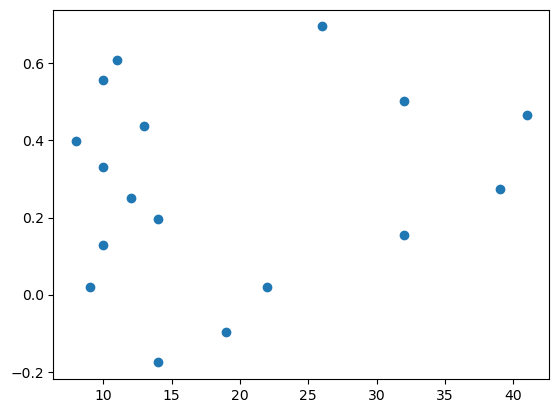

In [60]:
plt.scatter(x,cpe_y)

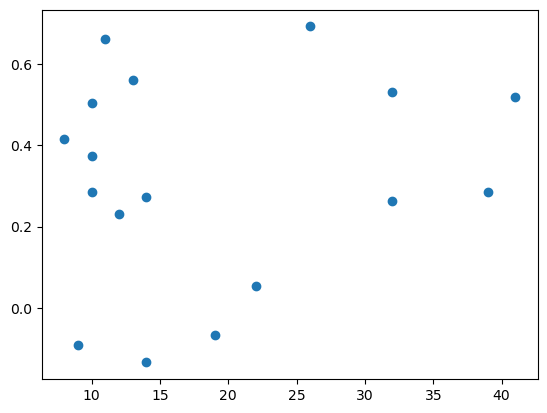

In [61]:
plt.scatter(x,regret_betas)

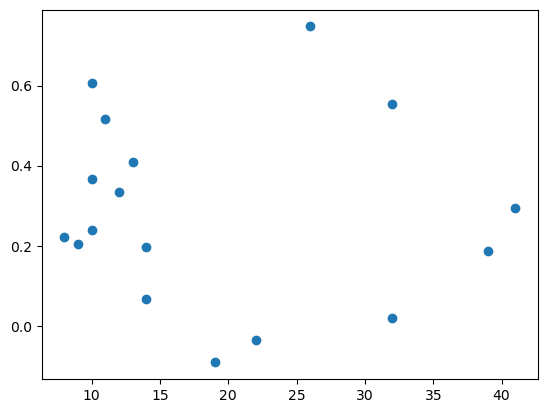

In [62]:
plt.scatter(x,relief_betas)

In [63]:
dep_regret_betas = regret_fits[dep_subj].iloc[-1]
nodep_regret_betas = regret_fits[nodep_subj].iloc[-1]

dep_cpe_betas = cpe_fits[dep_subj].iloc[-1]
nodep_cpe_betas = cpe_fits[nodep_subj].iloc[-1]

dep_relief_betas = relief_fits[dep_subj].iloc[-1]
nodep_relief_betas = relief_fits[nodep_subj].iloc[-1]

dep_full_regret_betas = full_fits[dep_subj].iloc[-2]
nodep_full_regret_betas = full_fits[nodep_subj].iloc[-2]

dep_full_relief_betas = full_fits[dep_subj].iloc[-1]
nodep_full_relief_betas = full_fits[nodep_subj].iloc[-1]

dep_full_rpe_betas = full_fits[dep_subj].iloc[-3]
nodep_full_rpe_betas = full_fits[nodep_subj].iloc[-3]


In [70]:
dep_regret_betas

DA9      0.530509
DA11     0.517907
MS017    0.691558
MS027    0.054984
MS029    0.262259
MS033    0.283920
Name: 4, dtype: float64

In [64]:
import scipy.stats as stats
stats.ttest_ind(dep_regret_betas, nodep_regret_betas, equal_var=False)


Ttest_indResult(statistic=0.9317360955458234, pvalue=0.3699222555436763)

In [65]:
stats.ttest_ind(dep_cpe_betas, nodep_cpe_betas, equal_var=False)


Ttest_indResult(statistic=0.8636407795394042, pvalue=0.4067464505765913)

In [66]:
stats.ttest_ind(dep_relief_betas, nodep_relief_betas, equal_var=False)


Ttest_indResult(statistic=0.11290507214587446, pvalue=0.9131317191417118)

In [67]:
stats.ttest_ind(dep_full_regret_betas, nodep_full_regret_betas, equal_var=False)


Ttest_indResult(statistic=1.519707352395277, pvalue=0.1535640060980519)

In [68]:
stats.ttest_ind(dep_full_relief_betas, nodep_full_relief_betas, equal_var=False)


Ttest_indResult(statistic=0.22651588960769808, pvalue=0.8238676097255413)

In [69]:
stats.ttest_ind(dep_full_rpe_betas, nodep_full_rpe_betas, equal_var=False)


Ttest_indResult(statistic=-1.165265446243338, pvalue=0.2628482227870624)

## Prospect Theory GLMs

PT models - 

1) PT (Util_s+Util_g) *validate this is better than Rutledge EV (PT1)
2) RPE PT (Util_s+Util_g+RPE)
3) CPE PT (Util_s+Util_g+tCPE) *tCPE always now
4) CPE+RPE PT (Util_s+Util_g+RPE+tCPE) 
5) Regret PT (Util_s+Util_g+tRegret) *omit RPE if model 4 > model 5
6) Relief PT (Util_s+Util_g+tRelief) *omit RPE if model 4 > model 5
7) Regret/Relief PT (Util_s+Util_g+tRegret+tRelief) 
8) RPE Regret (Util_s+Util_g+RPE+tRegret)
9) RPE Relief (Util_s+Util_g+RPE+tRelief)
10) RPE Regret/Relief PT (Util_s+Util_g+RPE+tRegret+tRelief) 

GLM Comparison - 

1) Rutledge EV (CR+EV)
2) RPE (CR+EV+RPE)
3) Counterfactual (CR+EV+tCPE) 
4) Counterfactual+RPE (CR+EV+RPE+tCPE)
5) Regret (CR+EV+regret) 
6) Relief (CR+EV+relief)
7) Regret/Relief (CR+EV+regret+relief)
8) RPE/Regret (CR+EV+RPE+Regret)
9) RPE/Relief (CR+EV+RPE+Relief)
10) RPE/Regret/Relief (CR+EV+RPE+regret+relief)


In [74]:
date = '06262023'
model_input_path = f'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/pt_model_input_data_{date}'
model_input = pd.read_csv(model_input_path)

In [75]:
pt1_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)"]
pt2_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
pt3_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt4_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt5_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
pt6_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt7_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt8_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
pt9_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt10_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


glm1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)"]
glm2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
glm3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm8_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm9_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm10_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [76]:
pt_glms_dict = {}
pt_glms_dict['Util'] = pt1_vars
pt_glms_dict['RPE'] = pt2_vars
pt_glms_dict['CPE'] = pt3_vars
pt_glms_dict['CPE_RPE'] = pt4_vars
pt_glms_dict['UtilReg'] = pt5_vars
pt_glms_dict['UtilRel'] = pt6_vars
pt_glms_dict['Reg_Rel'] = pt7_vars
pt_glms_dict['RPE_Reg'] = pt8_vars
pt_glms_dict['RPE_Rel'] = pt9_vars
pt_glms_dict['RPE_Reg_Rel'] = pt10_vars


In [77]:
glms_dict = {}
glms_dict['CR_EV'] = glm1_vars
glms_dict['RPE'] = glm2_vars
glms_dict['CPE'] = glm3_vars
glms_dict['CPE_RPE'] = glm4_vars
glms_dict['Regret'] = glm5_vars
glms_dict['Relief'] = glm6_vars
glms_dict['Regret_Relief'] = glm7_vars
glms_dict['RPE_Reg'] = glm8_vars
glms_dict['RPE_Rel'] = glm9_vars
glms_dict['RPE_Reg_Rel'] = glm10_vars


In [78]:
pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']
glms_list = ['CR_EV','RPE','CPE','CPE_RPE','Regret','Relief','Regret_Relief','RPE_Reg','RPE_Rel','RPE_Reg_Rel']


In [79]:
#find optim PT params

lam_method = 'exp'
pt_results = {}

for model in pt_list:

    reg_list = pt_glms_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    pt_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }

In [80]:

lam_method = 'exp'
glm_results = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    glm_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }

In [81]:
### use optimal parameters to run model 

pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']
lam_method = 'exp'
pt_data = {}

for model in pt_list:

    reg_list = pt_glms_dict[model]
    n_regs = int(len(reg_list)/3)
    params = pt_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    pt_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [82]:
### use optimal parameters to run model 

glms_list = ['CR_EV','RPE','CPE','CPE_RPE','Regret','Relief','Regret_Relief','RPE_Reg','RPE_Rel','RPE_Reg_Rel']
lam_method = 'exp'
glm_data = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)
    params = glm_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    glm_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [83]:
pt_data

{'Util': {'mood_est':           DA8       DA9      DA10      DA11     DA023     MS002     MS003  \
  0   -0.037348 -2.506247 -1.627254 -2.554567 -0.240460 -0.400959  0.260496   
  1   -0.010902 -0.252582 -1.471419 -1.929541 -0.617123 -0.138695 -0.710046   
  2    0.253535  0.206988  1.019775  0.680199  0.313904  0.418772  0.028980   
  3    0.024796  1.253894 -0.010358 -1.820611 -0.986637  0.517567 -1.460707   
  4    0.083268 -0.383500 -2.023673 -0.455347 -0.011550 -0.543448 -0.140152   
  ..        ...       ...       ...       ...       ...       ...       ...   
  795  0.204124 -0.097469  0.254796  0.276926  0.259656  0.216892  0.086287   
  796  0.125021  0.393414 -0.193669 -0.516660 -0.276095  0.114943 -0.621916   
  797  0.151296  0.609647  0.211063 -0.294763 -0.251899  0.238563 -0.664267   
  798  0.158205  0.297741  0.417972 -0.332730 -0.175520  0.276488 -0.502931   
  799  0.151989  0.477656 -0.123483 -0.179908 -0.113269  0.181752 -0.444859   
  
          MS016     MS017    

In [84]:
pt_list_noutil = ['RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']

gl_list_nocr = ['RPE','CPE','CPE_RPE','Regret','Relief','Regret_Relief','RPE_Reg','RPE_Rel','RPE_Reg_Rel']


In [85]:
for ix,s in enumerate(subj_ids):
    best_pt_bic = np.inf
    best_bic = np.inf
    best_pt_model_bic = []
    best_model_bic = []
    for model in pt_list_noutil:
        bic1 = pt_data[model]['bics2'][s]
        if bic1<best_pt_bic:
            best_pt_bic = bic1 
            best_pt_model_bic = model
    for model in gl_list_nocr:
        bic = glm_data[model]['bics2'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        
    print('best pt model bic for ',s,'is',best_pt_model_bic,best_pt_bic)
    print('best model bic for ',s,'is',best_model_bic,best_bic)

best pt model bic for  DA8 is RPE 33.334693988644915
best model bic for  DA8 is Relief 33.413593152598935
best pt model bic for  DA9 is CPE 33.08663617868557
best model bic for  DA9 is Relief 33.76635093215753
best pt model bic for  DA10 is UtilReg 33.08817554387474
best model bic for  DA10 is Relief 33.76835999154334
best pt model bic for  DA11 is CPE 32.200164251665264
best model bic for  DA11 is Relief 34.03145316017204
best pt model bic for  DA023 is CPE 33.79577418632164
best model bic for  DA023 is CPE 33.89801369212182
best pt model bic for  MS002 is UtilRel 33.30801090311781
best model bic for  MS002 is RPE 33.926111526248626
best pt model bic for  MS003 is UtilReg 33.35981610128606
best model bic for  MS003 is Relief 34.038213450221036
best pt model bic for  MS016 is CPE 33.693389899865736
best model bic for  MS016 is Relief 34.088214175689984
best pt model bic for  MS017 is CPE 33.485240111956855
best model bic for  MS017 is Relief 33.43645878297192
best pt model bic for  MS0

In [86]:
pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']

glms_list = ['CR_EV','RPE','CPE','CPE_RPE','Regret','Relief','Regret_Relief','RPE_Reg','RPE_Rel','RPE_Reg_Rel']


In [87]:
pt_bic1_means = []
for model in pt_list:
    pt_bic1_means.append(np.mean(np.array(list(pt_data[model]['bics1'].values()))))
    print(model,'PT bic1 mean',np.mean(np.array(list(pt_data[model]['bics1'].values()))))

glm_bic1_means = []
for model in glms_list:
    glm_bic1_means.append(np.mean(np.array(list(glm_data[model]['bics1'].values()))))
    print(model,'GLM bic1 mean',np.mean(np.array(list(glm_data[model]['bics1'].values()))))

Util PT bic1 mean 109.97848926691655
RPE PT bic1 mean 78.75415168570755
CPE PT bic1 mean 142.9590054436498
CPE_RPE PT bic1 mean 177.91824449509926
UtilReg PT bic1 mean 139.48838630292693
UtilRel PT bic1 mean 95.11902571822691
Reg_Rel PT bic1 mean 179.69122619557868
RPE_Reg PT bic1 mean 181.31459911896127
RPE_Rel PT bic1 mean 129.72950415076195
RPE_Reg_Rel PT bic1 mean 216.1433963680822
CR_EV GLM bic1 mean -151.07870297017774
RPE GLM bic1 mean -175.8689580698109
CPE GLM bic1 mean -164.7142688250831
CPE_RPE GLM bic1 mean -150.55978013128944
Regret GLM bic1 mean -173.7849800513261
Relief GLM bic1 mean -144.84157643101847
Regret_Relief GLM bic1 mean -167.251070595183
RPE_Reg GLM bic1 mean -145.5763349750442
RPE_Rel GLM bic1 mean -156.6708856662832
RPE_Reg_Rel GLM bic1 mean -129.13813217403415


In [88]:
pt_bic1_sum = []
for model in pt_list:
    pt_bic1_sum.append(np.sum(np.array(list(pt_data[model]['bics1'].values()))))
    print(model,'PT bic1 sum',np.sum(np.array(list(pt_data[model]['bics1'].values()))))

glm_bic1_sum = []
for model in glms_list:
    glm_bic1_sum.append(np.sum(np.array(list(glm_data[model]['bics1'].values()))))
    print(model,'GLM bic1 sum',np.sum(np.array(list(glm_data[model]['bics1'].values()))))

Util PT bic1 sum 1759.6558282706649
RPE PT bic1 sum 1260.0664269713209
CPE PT bic1 sum 2287.344087098397
CPE_RPE PT bic1 sum 2846.691911921588
UtilReg PT bic1 sum 2231.814180846831
UtilRel PT bic1 sum 1521.9044114916305
Reg_Rel PT bic1 sum 2875.059619129259
RPE_Reg PT bic1 sum 2901.0335859033803
RPE_Rel PT bic1 sum 2075.6720664121913
RPE_Reg_Rel PT bic1 sum 3458.294341889315
CR_EV GLM bic1 sum -2417.259247522844
RPE GLM bic1 sum -2813.9033291169744
CPE GLM bic1 sum -2635.4283012013298
CPE_RPE GLM bic1 sum -2408.956482100631
Regret GLM bic1 sum -2780.5596808212176
Relief GLM bic1 sum -2317.4652228962955
Regret_Relief GLM bic1 sum -2676.017129522928
RPE_Reg GLM bic1 sum -2329.2213596007073
RPE_Rel GLM bic1 sum -2506.734170660531
RPE_Reg_Rel GLM bic1 sum -2066.2101147845465


In [146]:
pt_bic2_means = []
for model in pt_list:
    pt_bic2_means.append(np.mean(np.array(list(pt_data[model]['bics2'].values()))))
    print(model,'PT bic mean',np.mean(np.array(list(pt_data[model]['bics2'].values()))))

glm_bic2_means = []
for model in glms_list:
    glm_bic2_means.append(np.mean(np.array(list(glm_data[model]['bics2'].values()))))
    print(model,'GLM bic mean',np.mean(np.array(list(glm_data[model]['bics2'].values()))))

Util PT bic mean 26.530346804781097
RPE PT bic mean 33.30973090572121
CPE PT bic mean 33.14921877132636
CPE_RPE PT bic mean 39.76314393068483
UtilReg PT bic mean 33.15789531917817
UtilRel PT bic mean 33.26881872063991
Reg_Rel PT bic mean 39.75871147643363
RPE_Reg PT bic mean 39.75465304412518
RPE_Rel PT bic mean 39.88361578154567
RPE_Reg_Rel PT bic mean 46.368904307989474
CR_EV GLM bic mean 27.18298978537383
RPE GLM bic mean 33.94628868011
CPE GLM bic mean 33.91840195699819
CPE_RPE GLM bic mean 40.58433899225081
Regret GLM bic mean 33.9410787350638
Relief GLM bic mean 33.868720226013025
Regret_Relief GLM bic mean 40.62606721841054
RPE_Reg GLM bic mean 40.571880379360195
RPE_Rel GLM bic mean 40.59961675608829
RPE_Reg_Rel GLM bic mean 47.232108129344766


In [147]:
pt_bic2_sum = []
for model in pt_list:
    pt_bic2_sum.append(np.sum(np.array(list(pt_data[model]['bics2'].values()))))
    print(model,'PT bic sum',np.sum(np.array(list(pt_data[model]['bics2'].values()))))

glm_bic2_sum = []
for model in glms_list:
    glm_bic2_sum.append(np.sum(np.array(list(glm_data[model]['bics2'].values()))))
    print(model,'GLM bic sum',np.sum(np.array(list(glm_data[model]['bics2'].values()))))

Util PT bic sum 424.48554887649755
RPE PT bic sum 532.9556944915394
CPE PT bic sum 530.3875003412218
CPE_RPE PT bic sum 636.2103028909573
UtilReg PT bic sum 530.5263251068507
UtilRel PT bic sum 532.3010995302386
Reg_Rel PT bic sum 636.1393836229381
RPE_Reg PT bic sum 636.0744487060028
RPE_Rel PT bic sum 638.1378525047307
RPE_Reg_Rel PT bic sum 741.9024689278316
CR_EV GLM bic sum 434.9278365659813
RPE GLM bic sum 543.14061888176
CPE GLM bic sum 542.694431311971
CPE_RPE GLM bic sum 649.3494238760129
Regret GLM bic sum 543.0572597610208
Relief GLM bic sum 541.8995236162084
Regret_Relief GLM bic sum 650.0170754945686
RPE_Reg GLM bic sum 649.1500860697631
RPE_Rel GLM bic sum 649.5938680974126
RPE_Reg_Rel GLM bic sum 755.7137300695163


In [94]:
pt_aic_means = []
for model in pt_list:
    pt_aic_means.append(np.mean(np.array(list(pt_data[model]['aic'].values()))))
    print(model,'PT aic mean',np.mean(np.array(list(pt_data[model]['aic'].values()))))

glm_aic_means = []
for model in glms_list:
    glm_aic_means.append(np.mean(np.array(list(glm_data[model]['aic'].values()))))
    print(model,'GLM aic mean',np.mean(np.array(list(glm_data[model]['aic'].values()))))

Util PT aic mean 91.24004235624487
RPE PT aic mean 55.33109304736793
CPE PT aic mean 119.53594680531018
CPE_RPE PT aic mean 149.8105741290917
UtilReg PT aic mean 116.0653276645873
UtilRel PT aic mean 71.6959670798873
Reg_Rel PT aic mean 151.58355582957114
RPE_Reg PT aic mean 153.20692875295373
RPE_Rel PT aic mean 101.62183378475439
RPE_Reg_Rel PT aic mean 183.3511142744067
CR_EV GLM aic mean -169.81714988084946
RPE GLM aic mean -199.29201670815053
CPE GLM aic mean -188.13732746342274
CPE_RPE GLM aic mean -178.66745049729698
Regret GLM aic mean -197.20803868966573
Relief GLM aic mean -168.2646350693581
Regret_Relief GLM aic mean -195.3587409611906
RPE_Reg GLM aic mean -173.6840053410518
RPE_Rel GLM aic mean -184.7785560322908
RPE_Reg_Rel GLM aic mean -161.93041426770964


In [95]:
pt_aic_sum = []
for model in pt_list:
    pt_aic_sum.append(np.sum(np.array(list(pt_data[model]['aic'].values()))))
    print(model,'PT aic sum',np.sum(np.array(list(pt_data[model]['aic'].values()))))

glm_aic_sum = []
for model in glms_list:
    glm_aic_sum.append(np.sum(np.array(list(glm_data[model]['aic'].values()))))
    print(model,'GLM aic mean',np.sum(np.array(list(glm_data[model]['aic'].values()))))

Util PT aic sum 1459.840677699918
RPE PT aic sum 885.2974887578869
CPE PT aic sum 1912.5751488849628
CPE_RPE PT aic sum 2396.969186065467
UtilReg PT aic sum 1857.0452426333968
UtilRel PT aic sum 1147.1354732781967
Reg_Rel PT aic sum 2425.3368932731382
RPE_Reg PT aic sum 2451.3108600472597
RPE_Rel PT aic sum 1625.9493405560702
RPE_Reg_Rel PT aic sum 2933.6178283905074
CR_EV GLM aic mean -2717.0743980935913
RPE GLM aic mean -3188.6722673304084
CPE GLM aic mean -3010.1972394147638
CPE_RPE GLM aic mean -2858.6792079567517
Regret GLM aic mean -3155.3286190346516
Relief GLM aic mean -2692.2341611097295
Regret_Relief GLM aic mean -3125.7398553790495
RPE_Reg GLM aic mean -2778.944085456829
RPE_Rel GLM aic mean -2956.4568965166527
RPE_Reg_Rel GLM aic mean -2590.886628283354


# Utility models with util rpe/cpe

In [ ]:
pt1_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)"]
pt2_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
pt3_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt4_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt5_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
pt6_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt7_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt8_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
pt9_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
pt10_vars = ["util_s(t-1)","util_s(t-2)","util_s(t-3)","util_g(t-1)","util_g(t-2)","util_g(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


# PT Params with BDI

In [118]:
bdi_info = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='pt_info', usecols=[1])
pt_bdi_list = list(bdi_info.SWB_BDI)

bdi_swb_info = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[4])
swb_bdi_list = list(bdi_swb_info.SWB_BDI)


#np_bdi_list = list(bdi_info.BDI)

In [114]:
pt_bdi_list

[19,
 6,
 8,
 13,
 32,
 11,
 41,
 14,
 14,
 8,
 7,
 10,
 26,
 12,
 10,
 16,
 7,
 11,
 22,
 12,
 32,
 19]

In [103]:
pt_params_df= pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/swb_base_pt_params_06262023.csv')

In [115]:
pt_params_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi
0,DA4,2.077014,0.001000,7.876018,19
1,DA5,1.666608,0.001000,3.370105,6
2,DA06,1.483146,0.261268,3.924275,8
3,DA8,1.212121,5.111118,2.625557,13
4,DA9,1.484386,0.836855,3.261053,32
5,DA10,0.781768,1.727190,3.058603,11
6,DA11,1.199625,0.226256,1.527751,41
7,DA023,0.994608,1.864381,2.089041,14
8,MS002,0.818264,3.179061,1.528016,14
9,MS003,0.733145,0.001000,5.118690,8


In [116]:
pt_params_df['swb_bdi'] = pt_bdi_list

In [117]:
pt_params_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi
0,DA4,2.077014,0.001000,7.876018,19
1,DA5,1.666608,0.001000,3.370105,6
2,DA06,1.483146,0.261268,3.924275,8
3,DA8,1.212121,5.111118,2.625557,13
4,DA9,1.484386,0.836855,3.261053,32
5,DA10,0.781768,1.727190,3.058603,11
6,DA11,1.199625,0.226256,1.527751,41
7,DA023,0.994608,1.864381,2.089041,14
8,MS002,0.818264,3.179061,1.528016,14
9,MS003,0.733145,0.001000,5.118690,8


In [107]:
pt_list = ['Util','RPE','CPE','CPE_RPE','UtilReg','UtilRel','Reg_Rel','RPE_Reg','RPE_Rel','RPE_Reg_Rel']

In [108]:
pt_results['CPE']['param_fits']

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030
0,0.171351,0.072487,0.354708,7.444794e-21,2.677294e-19,0.856616,1.517024e-19,0.261312,0.255564,0.335067,0.091671,0.426782,1.000000,1.000000,0.433926,1.279808e-16
1,0.708311,0.547027,0.746319,1.690040e-01,-6.132436e-02,0.414117,-3.125438e-02,0.165857,0.614298,-0.001984,0.128029,0.327324,0.226285,0.118272,0.173143,6.155183e-02
2,0.086225,-1.246502,0.059987,-3.404682e-01,3.737496e-01,-0.155902,7.372084e-01,0.112364,-0.047684,0.412188,3.736694,0.459579,0.212023,-0.337535,0.323970,5.378480e-01
3,-0.016426,0.818169,0.421719,1.094101e+00,7.089829e-02,0.185399,3.357621e-02,0.273438,0.375122,0.477538,-0.171157,-0.174507,-0.047033,0.287910,0.372673,-4.211365e-01
4,0.798178,0.585449,0.531952,5.795859e-01,-1.695847e-01,0.093518,4.241566e-01,0.307402,0.706125,0.295135,0.528219,0.172399,0.116089,0.014636,0.197987,-1.018461e-01


In [109]:
util_fits = pt_results['Util']['param_fits'] 
rpe_fits = pt_results['RPE']['param_fits'] 
cpe_fits = pt_results['CPE']['param_fits'] 
cpe_rpe_fits = pt_results['CPE_RPE']['param_fits'] 
regret_fits = pt_results['UtilReg']['param_fits'] 
relief_fits = pt_results['UtilRel']['param_fits'] 
reg_rel_fits = pt_results['Reg_Rel']['param_fits'] 
rpe_reg_fits = pt_results['RPE_Reg']['param_fits'] 
rpe_rel_fits = pt_results['RPE_Rel']['param_fits'] 
rpe_reg_rel_fits = pt_results['RPE_Reg_Rel']['param_fits'] 

In [110]:
util_fits

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030
0,0.109970,0.165127,0.511086,3.164519e-21,3.067121e-22,1.000000,4.340732e-16,0.363830,0.724421,0.997358,0.318745,0.412511,0.145555,1.000000,0.423191,4.865464e-20
1,0.178917,0.097486,0.291534,-3.948921e-02,3.379698e-02,0.227056,-2.195210e-01,-0.112674,0.039380,-0.314458,-0.232347,0.128221,0.017415,0.095655,-0.071805,1.294705e-01
2,-0.000557,-1.402415,-0.110339,-1.765907e-01,3.552507e-01,-0.141384,7.503986e-01,0.239998,0.219351,0.444632,3.546436,0.451213,0.646278,-0.331553,0.404117,5.480460e-01
3,0.062522,0.742114,0.502410,7.484756e-01,8.161763e-02,0.147485,-1.428509e-01,0.010835,0.151426,0.135382,-0.247974,-0.175569,-0.183507,0.270773,0.209398,-4.307829e-01


In [111]:
util_s_weights = util_fits.iloc[2]
util_g_weights = util_fits.iloc[3]
rpe_weights = rpe_fits.iloc[-1]
cpe_weights = cpe_fits.iloc[-1]
cpe_rpe_weights = cpe_rpe_fits.iloc[-1]
regret_weights = regret_fits.iloc[-1]
relief_weights = relief_fits.iloc[-1]
reg_rel_weights = reg_rel_fits.iloc[-1]
rel_reg_weights = reg_rel_fits.iloc[-2]
reg_rpe_rel_weights = rpe_reg_rel_fits.iloc[-2]



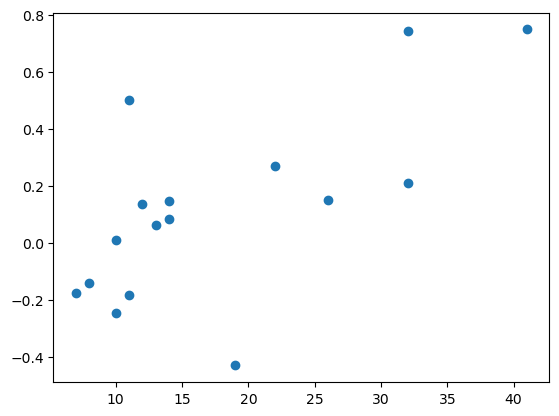

In [119]:
plt.scatter(swb_bdi_list,util_g_weights)

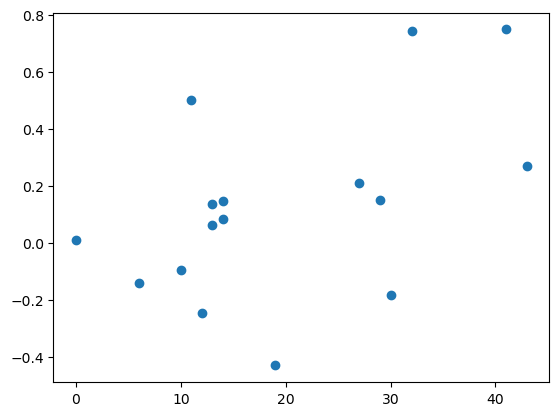

In [161]:
plt.scatter(np_bdi_list,util_g_weights)

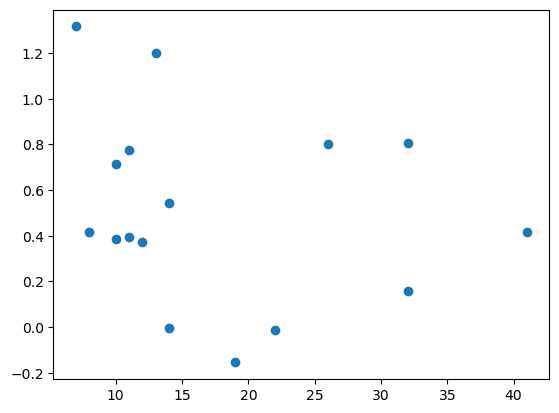

In [120]:
plt.scatter(swb_bdi_list,rpe_weights)

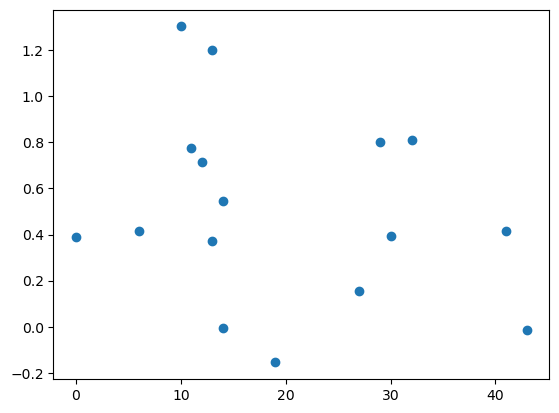

In [162]:
plt.scatter(np_bdi_list,rpe_weights)

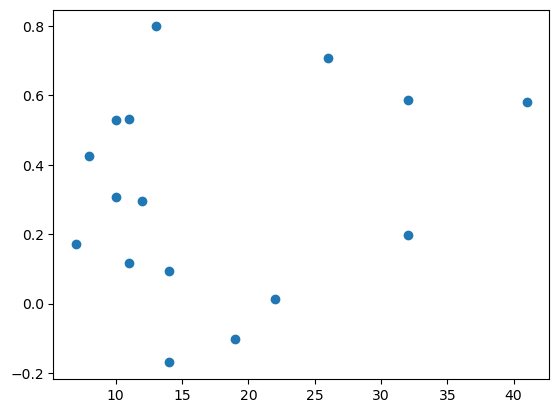

In [121]:
plt.scatter(swb_bdi_list,cpe_weights)

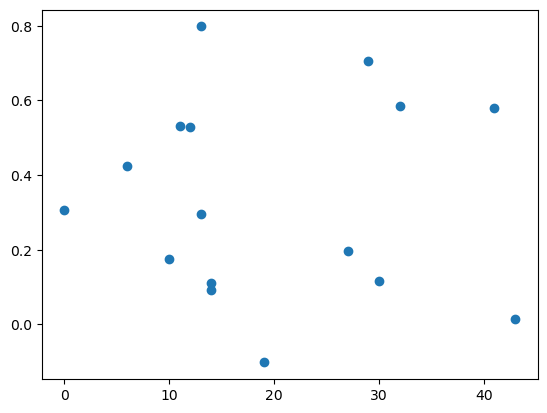

In [166]:
plt.scatter(np_bdi_list,cpe_weights)

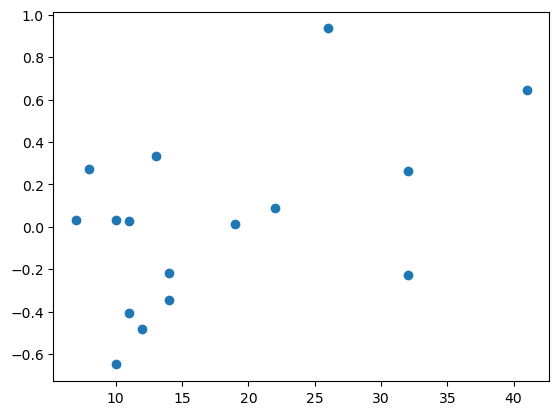

In [122]:
plt.scatter(swb_bdi_list,cpe_rpe_weights)

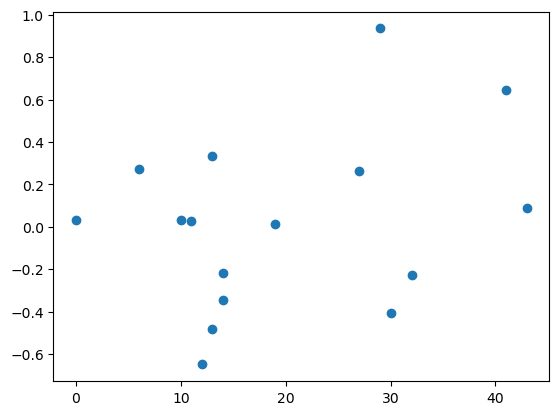

In [169]:
plt.scatter(np_bdi_list,cpe_rpe_weights)

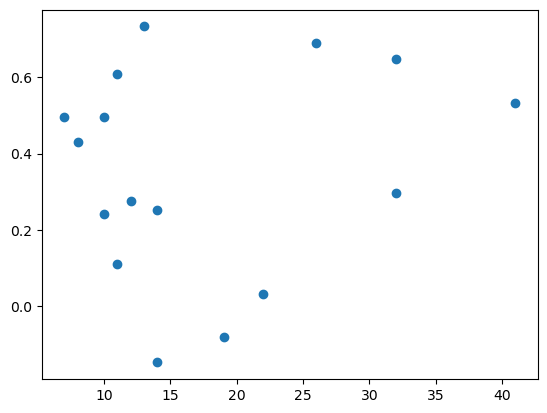

In [123]:
plt.scatter(swb_bdi_list,regret_weights)

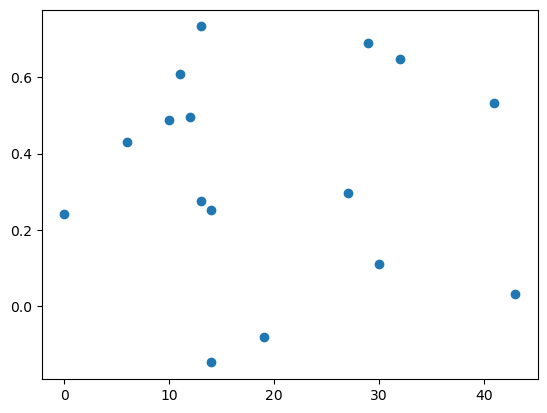

In [171]:
plt.scatter(np_bdi_list,regret_weights)

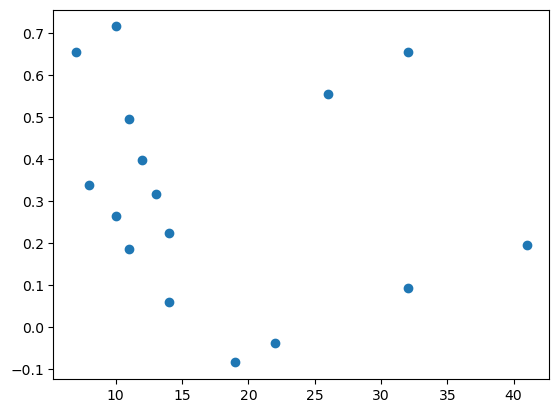

In [124]:
plt.scatter(swb_bdi_list,relief_weights)

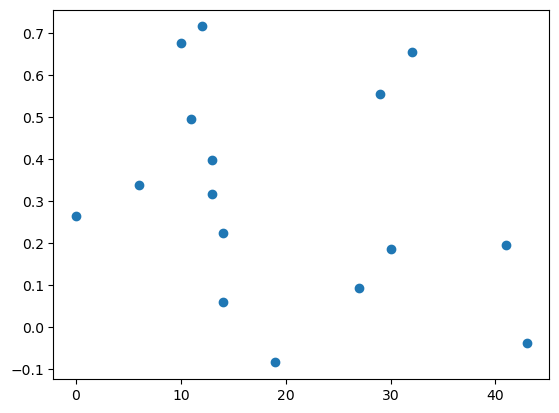

In [173]:
plt.scatter(np_bdi_list,relief_weights)

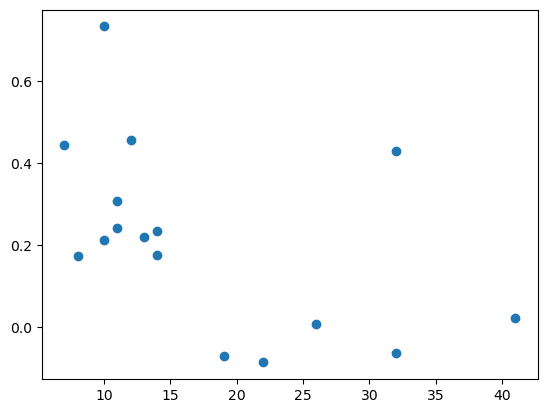

In [125]:
plt.scatter(swb_bdi_list,reg_rel_weights)

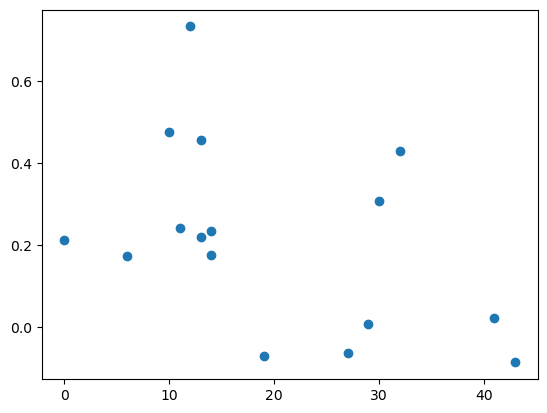

In [175]:
plt.scatter(np_bdi_list,reg_rel_weights)

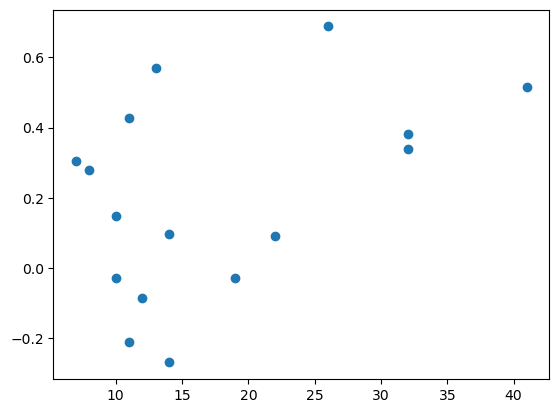

In [126]:
plt.scatter(swb_bdi_list,rel_reg_weights)

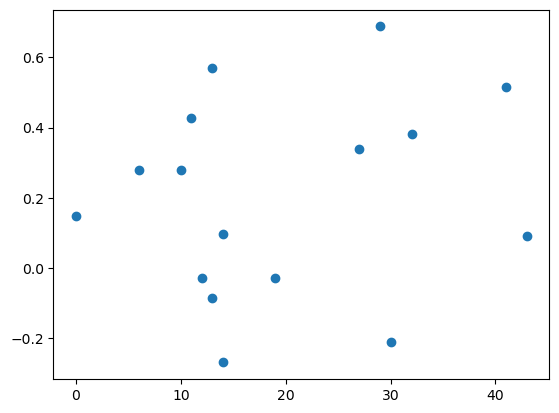

In [178]:
plt.scatter(np_bdi_list,rel_reg_weights)

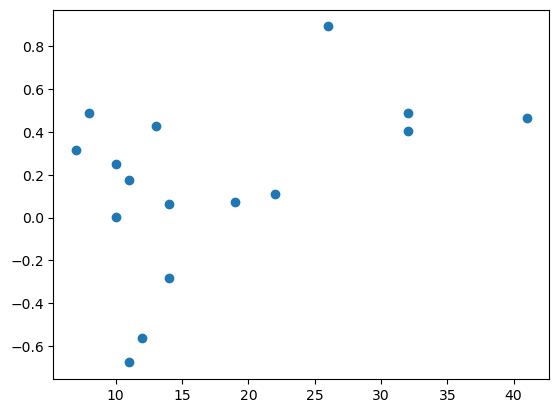

In [127]:
plt.scatter(swb_bdi_list,reg_rpe_rel_weights)

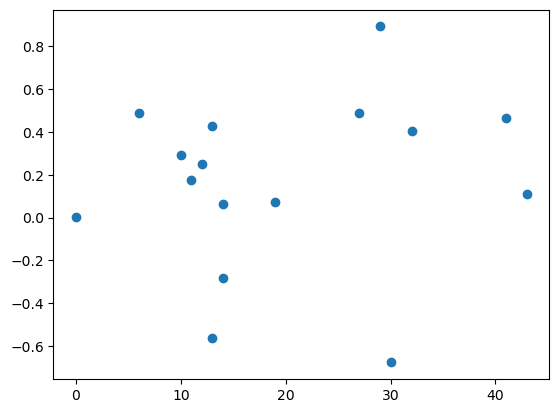

In [180]:
plt.scatter(np_bdi_list,reg_rpe_rel_weights)

In [181]:
pt_params_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi,np_bdi
0,DA8,1.212121,5.111118,2.625557,13,13
1,DA9,1.484386,0.836855,3.261052,32,32
2,DA10,0.781768,1.727190,3.058603,11,11
3,DA11,1.199625,0.226255,1.527750,41,41
4,DA023,0.994608,1.864381,2.089041,14,14
5,MS002,0.818264,3.179061,1.528016,14,14
6,MS003,0.733145,0.001000,5.118690,8,6
7,MS016,0.623760,0.969737,6.760218,10,0
8,MS017,1.325976,0.989178,6.336838,26,29
9,MS019,1.140644,0.001000,6.780384,12,13


(array([1., 0., 1., 7., 2., 3., 2., 2., 2., 2.]),
 array([1.00000000e-03, 2.08601365e-01, 4.16202729e-01, 6.23804094e-01,
        8.31405459e-01, 1.03900682e+00, 1.24660819e+00, 1.45420955e+00,
        1.66181092e+00, 1.86941228e+00, 2.07701365e+00]),
 <BarContainer object of 10 artists>)

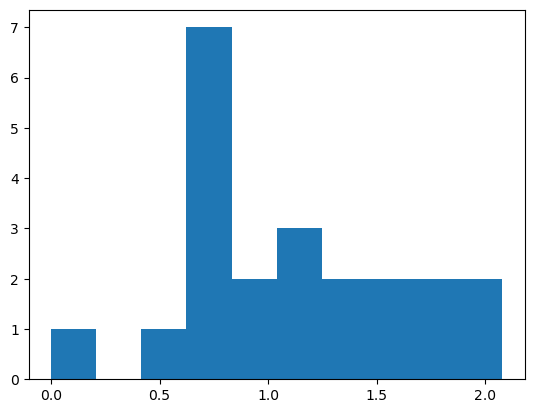

In [128]:
plt.hist(pt_params_df.Risk_Aversion)

(array([8., 6., 2., 1., 0., 1., 0., 0., 1., 3.]),
 array([1.0000e-03, 6.0090e-01, 1.2008e+00, 1.8007e+00, 2.4006e+00,
        3.0005e+00, 3.6004e+00, 4.2003e+00, 4.8002e+00, 5.4001e+00,
        6.0000e+00]),
 <BarContainer object of 10 artists>)

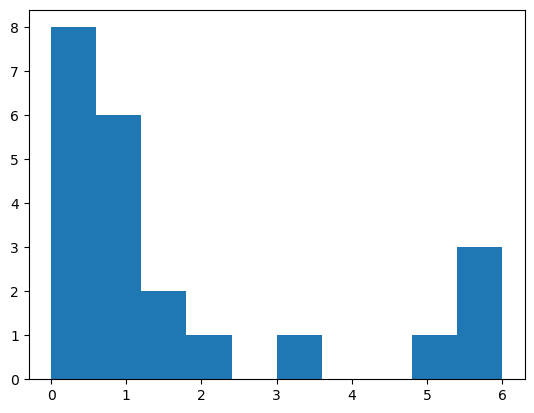

In [129]:
plt.hist(pt_params_df.Loss_Aversion)

In [130]:
swbdep_df = pt_params_df[pt_params_df.swb_bdi>=20]
noswbdep_df = pt_params_df[pt_params_df.swb_bdi<20]

In [131]:
npdep_df = pt_params_df[pt_params_df.swb_bdi>=20]
nonpdep_df = pt_params_df[pt_params_df.swb_bdi<20]

In [132]:
npdep_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi
4,DA9,1.484386,0.836855,3.261053,32
6,DA11,1.199625,0.226256,1.527751,41
12,MS017,1.325976,0.989178,6.336838,26
18,MS027,0.641948,0.648616,5.595923,22
20,MS029,0.001000,0.603489,0.723385,32


In [133]:
nonpdep_df

,PatientID,Risk_Aversion,Loss_Aversion,Inverse_Temperature,swb_bdi
0,DA4,2.077014,0.001000,7.876018,19
1,DA5,1.666608,0.001000,3.370105,6
2,DA06,1.483146,0.261268,3.924275,8
3,DA8,1.212121,5.111118,2.625557,13
5,DA10,0.781768,1.727190,3.058603,11
7,DA023,0.994608,1.864381,2.089041,14
8,MS002,0.818264,3.179061,1.528016,14
9,MS003,0.733145,0.001000,5.118690,8
10,MS004,0.711023,6.000000,0.316979,7
11,MS016,0.623760,0.969737,6.760218,10


In [144]:
import scipy.stats as stats
stats.ttest_ind(npdep_df.Risk_Aversion, nonpdep_df.Risk_Aversion, equal_var=False)


Ttest_indResult(statistic=-0.7492731801563348, pvalue=0.4840673876711751)

In [135]:
import scipy.stats as stats
stats.ttest_ind(swbdep_df.Loss_Aversion, noswbdep_df.Loss_Aversion, equal_var=False)

Ttest_indResult(statistic=-2.392966858837926, pvalue=0.028143991516558397)

In [145]:
import scipy.stats as stats
stats.ttest_ind(swbdep_df.Inverse_Temperature, noswbdep_df.Inverse_Temperature, equal_var=False)

Ttest_indResult(statistic=-0.32006344507636436, pvalue=0.7583405097413587)

In [136]:
swbdep_df.Risk_Aversion.mean()

0.9305867646048824

In [137]:
noswbdep_df.Risk_Aversion.mean()

1.1527930521249394

In [138]:
swbdep_df.Loss_Aversion.mean()

0.6608787571318889

In [139]:
noswbdep_df.Loss_Aversion.mean()

2.0386840553284906

In [140]:
npdep_df.Risk_Aversion.mean()

0.9305867646048824

In [141]:
nonpdep_df.Risk_Aversion.mean()

1.1527930521249394

In [142]:
npdep_df.Loss_Aversion.mean()

0.6608787571318889

In [143]:
nonpdep_df.Loss_Aversion.mean()

2.0386840553284906

# Model Figures

In [ ]:
#model comparison fig
rutledge_bic1 = np.array(list(cf_results_dict['rutledge']['bics1'].values()))
total_cpe_bic1 = np.array(list(cf_results_dict['total_cpe']['bics1'].values()))
regret_bic1 = np.array(list(cf_results_dict['regret']['bics1'].values()))
relief_bic1 = np.array(list(cf_results_dict['relief']['bics1'].values()))
combo_bic1 = np.array(list(cf_results_dict['combo']['bics1'].values()))

In [ ]:
bar_data = pd.DataFrame(columns=['RPE','CPE','Regret','Relief','CPE Split'])
bar_data['RPE'] = rutledge_bic1
bar_data['CPE'] = total_cpe_bic1
bar_data['Regret'] = regret_bic1
bar_data['Relief'] = relief_bic1
bar_data['CPE Split'] = combo_bic1

In [ ]:
#magma,cubehelix,twilight
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=bar_data, errorbar=('ci',50),order=['Relief','Regret','RPE','CPE'],saturation=0.8,palette='flare',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket
ax.set_title('SWB Model Evaluation',weight='semibold',fontsize=18,y=1.025)
#ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
ax.tick_params(labelsize=12)




In [ ]:
mood_est = list(pd.DataFrame.mean(cf_results_dict['total_cpe']['mood_est'],axis=1))

(-1.25, 1.25)

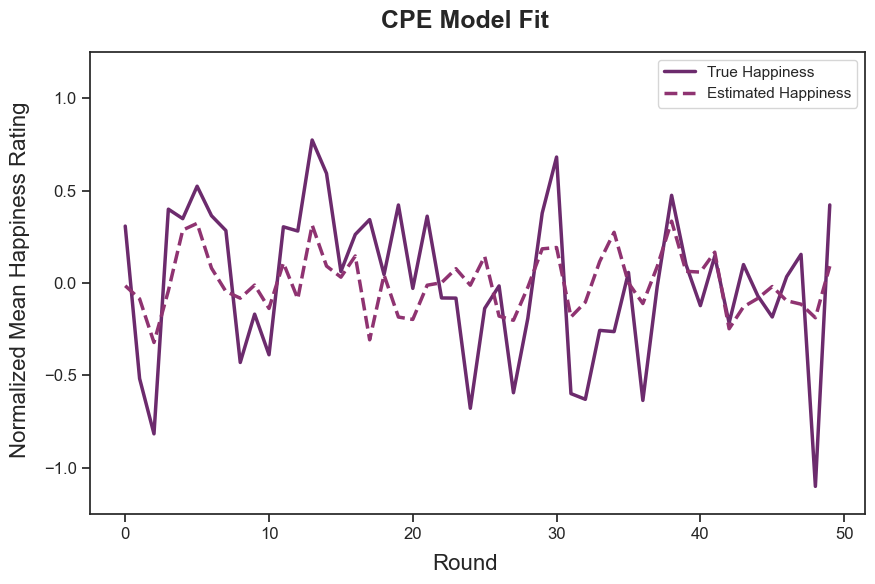

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='ticks',font='Arial',palette='flare_r') 
sns.lineplot(x=np.arange(0,50), y=rate_means[:50],label='True Happiness',linewidth=2.5)
sns.lineplot(x=np.arange(0,50), y=mood_est[:50],label='Estimated Happiness',linestyle='dashed',linewidth=2.5)
fig.suptitle('CPE Model Fit',font='Arial',weight ='semibold',fontsize=18,y=0.95)
fig.supxlabel('Round',font='Arial',fontsize=16,y=0.01)
fig.supylabel('Normalized Mean Happiness Rating',font='Arial',fontsize=16,x=0.045)
ax.tick_params(labelsize=12)
ax.set_ylim(-1.25,1.25)



In [ ]:
lams = cf_results_dict['combo']['param_fits'].iloc[0]
b_cr = cf_results_dict['combo']['param_fits'].iloc[2]
b_ev = cf_results_dict['combo']['param_fits'].iloc[3]
b_reg = cf_results_dict['combo']['param_fits'].iloc[4]
b_rel = cf_results_dict['combo']['param_fits'].iloc[5]
l = np.mean(np.array(lams))
cr = np.mean(np.array(b_cr))
ev = np.mean(np.array(b_ev))
reg = np.mean(np.array(b_reg))
rel = np.mean(np.array(b_rel))
import itertools

weights_plot_df = pd.DataFrame(columns=['trial','Regressor','Weight_Estimate'])
weights_plot_df['trial'] = ['t1','t2','t3']*4
weights_plot_df['Regressor'] = list(itertools.chain.from_iterable([['Certain Reward']*3,['Expected Value']*3,['Regret']*3,['Relief']*3]))



#cr
cr_t1 = cr
cr_t2 = cr*l
cr_t3 = cr*(l**2)

#ev
ev_t1 = ev
ev_t2 = ev*l
ev_t3 = ev*(l**2)

#reg
reg_t1 = reg
reg_t2 = reg*l
reg_t3 = reg*(l**2)

#rel
rel_t1 = rel
rel_t2 = rel*l
rel_t3 = rel*(l**2)

weights_plot_df['Weight_Estimate'] = [cr_t1,cr_t2,cr_t3,ev_t1,ev_t2,ev_t3,reg_t1,reg_t2,reg_t3,rel_t1,rel_t2,rel_t3]


In [ ]:
#weights plot
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(17,5),sharey=True)
sns.set_theme(style='white',font='Arial') 
ax3.tick_params(labelsize=12)
sns.barplot(ax=ax1,data=weights_plot_df[weights_plot_df['Regressor']== 'Regret'],x='trial',y='Weight_Estimate',palette='Reds_r')
sns.barplot(ax=ax2,data=weights_plot_df[weights_plot_df['Regressor']== 'Relief'],x='trial',y='Weight_Estimate',palette='ocean_r')
sns.barplot(ax=ax3,data=weights_plot_df[weights_plot_df['Regressor']== 'Expected Value'],x='trial',y='Weight_Estimate',palette='YlGn_r')
sns.barplot(ax=ax4,data=weights_plot_df[weights_plot_df['Regressor']== 'Certain Reward'],x='trial',y='Weight_Estimate',palette='Purples_r')
ax1.set_ylim(0,0.65)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Regret',weight='medium',fontsize=14,y=1.02)

ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Relief',weight='medium',fontsize=14,y=1.02)

ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Expected Value',weight='medium',fontsize=14,y=1.02)

ax4.set_ylabel(None)
ax4.set_xlabel(None)
ax4.tick_params(labelsize=12)
ax4.set_title('Certain Reward',weight='medium',fontsize=14,y=1.02)

fig.suptitle('Model Estimates of Regressor Weights',weight='semibold',fontsize=18, y=1.025)
fig.supxlabel('Count of Trials Preceeding Happiness Rating',weight='medium',fontsize=16,y=0.01)
fig.supylabel('Weight Estimate',weight='medium',fontsize=16,x=0.085)




In [ ]:
#weights plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
sns.set_theme(style='white',font='Arial') 
ax3.tick_params(labelsize=12)
sns.barplot(ax=ax1,data=weights_plot_df[weights_plot_df['Regressor']== 'Regret'],x='trial',y='Weight_Estimate',palette='flare_r')
sns.barplot(ax=ax2,data=weights_plot_df[weights_plot_df['Regressor']== 'Relief'],x='trial',y='Weight_Estimate',palette='BuGn_r')

ax1.set_ylim(0,0.65)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Regret',weight='medium',fontsize=14,y=1.02)

ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Relief',weight='medium',fontsize=14,y=1.02)

fig.suptitle('Weight of Counterfactual Prediction Errors on Happiness Ratings',weight='semibold',fontsize=18, y=1.025)
fig.supxlabel('Count of Trials Preceeding Happiness Rating',weight='medium',fontsize=16)
fig.supylabel('Weight Estimate',weight='medium',fontsize=16,x=0.05)




In [ ]:
fig,ax = plt.subplots(1,4,figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=bar_data, errorbar=('ci',50),order=['CPE Split','Relief','Regret','RPE','CPE'],saturation=0.8,palette='flare',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket
ax.set_title('SWB Model Evaluation',weight='semibold',fontsize=18,y=1.025)
#ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
ax.tick_params(labelsize=12)


In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
sns.set_theme(style='ticks',font='Arial',palette='mako_r') #magma_r,gnuplot,paired,cubehelix_r
sns.regplot(data=gamble_plot,ax=ax1,x='loss_x',y='loss_y',ci=68,logistic=True,scatter=False)
sns.regplot(data=gamble_plot,ax=ax2,x='mix_x',y='mix_y',ci=68,logistic=True,scatter=False)
sns.regplot(data=gamble_plot,ax=ax3,x='gain_x',y='gain_y',ci=68,logistic=True,scatter=False)
ax1.set_ylim(0,1)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Loss Trials',weight='medium',fontsize=15,y=1.02)
ax2.set_ylim(0,1)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Mix Trials',weight='medium',fontsize=15,y=1.02)
ax3.set_ylim(0,1)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Gain Trials',weight='medium',fontsize=15,y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.025,weight='medium',fontsize=16)
fig.supylabel('Proportion of Gamble Choices',x=0.05,weight='medium',fontsize=16)
fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

References:
- https://shawnrhoads.github.io/gu-psyc-347/module-02-01_Nonlinear-Modeling.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
- https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult
- https://www.nedcharles.com/regression/Nonlinear_Least_Squares_Regression_For_Python.html
